<a href="https://colab.research.google.com/github/karan-1700/Utilities/blob/main/SSRAN_on_Sentinel_Desis_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting Google Drive**

In [ ]:
# Mount the COLAB with Google Drive to load the dataset
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import os
os.getcwd()

'/gdrive'

In [ ]:
!ls

MyDrive  Shareddrives


In [ ]:
os.chdir("./MyDrive/Colab Notebooks/Olds_college_code/SSRAN-main/Data")
!pwd

/gdrive/MyDrive/Colab Notebooks/Olds_college_code/SSRAN-main/Data


# **Main Code**

In [ ]:
!pip install imagecodecs
!pip install sewar --upgrade

In [ ]:
# importing necessary packages
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
from skimage.io import imread

# **data_dtype**

In [ ]:
data_dtype = np.float16
training_data_folder = "training_data_5"

## **Initialize the network architecture**

In [ ]:
# -------------------------------------------------------parameter setting-------------------------------------------------------------
patch_size = 50            # input size of network
stride = 25

In [ ]:
Band_MSI =  12
Band_HSI =  235

In [ ]:
!pwd

/gdrive/MyDrive/Colab Notebooks/Olds_college_code/SSRAN-main/Data


In [ ]:
from training_data_1.exact_SSRAN_network_architecture_Karan import SSRAN
model = SSRAN.build(width=patch_size, height=patch_size,
                    depth=Band_MSI,
                    stages=3,
                    output_bands=Band_HSI)

## **Check number of samples available for training, validation and testing.**

In [ ]:
def get_sample_count():
    dataset_types = ["train_50x50patches", "validation_50x50patches", "test_50x50patches"]

    import h5py
    for dataset_type in dataset_types:
        hdf5_path = "./{}/{}.hdf5".format(training_data_folder, dataset_type)
        db = h5py.File(hdf5_path)

        print(dataset_type)
        print("X.shape = ", db["MSI_data"].shape)
        print("y.shape = ", db["HSI_data"].shape)
        print()

get_sample_count()


train_50x50patches
X.shape =  (588, 50, 50, 12)
y.shape =  (588, 50, 50, 235)

validation_50x50patches
X.shape =  (98, 50, 50, 12)
y.shape =  (98, 50, 50, 235)

test_50x50patches
X.shape =  (96, 50, 50, 12)
y.shape =  (96, 50, 50, 235)



## **Get date time for storing images and models**

In [ ]:
def get_date_time_str():
    from datetime import datetime
    import pytz
    current_dt = datetime.now(pytz.timezone('America/Edmonton'))
    date_time_str =  str(current_dt.day) + "_" + str(current_dt.month) + "_" + str(current_dt.year) + \
                      "_" + str(current_dt.hour) + "_" + str(current_dt.minute) + "_" + str(current_dt.second)
    # print("date_time_str = ", date_time_str)

    return date_time_str

# Get date time for storing images and models
date_time_str = get_date_time_str()
print("date_time_str = ", date_time_str)

date_time_str =  15_1_2024_14_9_0


## **Set Training Parameters**

In [ ]:
# # -------------------------------------------------------parameter setting-------------------------------------------------------------
epoch = 300                       # epoch size
batch_size = 64                   # batch size
learning_rate_base = 0.01         # learning rate
# num_epoch_deacy = 70              # deacy for learnin_rate_base
# learning_rate_decay_factor = 0.1  # learning rate decay


In [ ]:
# -------------------------------------- Define LOSS, OPTIMIZER and EVALUATION METRICS ------------------------------------
# L2 loss
import tensorflow as tf

# Mean Squared Error (MSE) loss function
# Loss function used in SSRAN paper
def mse_loss(y_true, y_pred):
    L2_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return L2_loss

# # Mean Squared Error (MSE) loss + L1 Regularization
# def mse_loss_l1(y_true, y_pred):
#     lambda_value = 0.01
#     mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
#     regularization_term = lambda_value * tf.reduce_sum(tf.abs(model.weights))
#     L1_loss = mse_loss + regularization_term
#     return L1_loss

# optimizer
from tensorflow.keras.optimizers import Adam, SGD
# opt = Adam(learning_rate=learning_rate_base, epsilon=1e-05)
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Evaluation Metrics
from tensorflow.keras import metrics
rmse = metrics.RootMeanSquaredError(name="RMSE")
mae = metrics.MeanAbsoluteError(name="MAE")
metrics = [rmse, mae]


In [ ]:
# lambda_value = 0.001
# # Add L1 regularization term
# model.add_loss(lambda: lambda_value * tf.reduce_sum([tf.reduce_sum(tf.abs(w)) for w in model.trainable_weights]))
# # Add L2 regularization term
# # model.add_loss(lambda: lambda_value * tf.reduce_sum([tf.reduce_sum(tf.square(w)) for w in model.trainable_weights]))


In [ ]:
model.compile(loss=mse_loss, optimizer=opt, metrics=metrics)

In [ ]:
model.summary()

Model: "SSRAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 12)]         0         []                            
                                                                                                  
 conv0 (Conv2D)              (None, 50, 50, 64)           832       ['input_1[0][0]']             
                                                                                                  
 relu0 (Activation)          (None, 50, 50, 64)           0         ['conv0[0][0]']               
                                                                                                  
 spa1_conv1 (Conv2D)         (None, 50, 50, 64)           36928     ['relu0[0][0]']               
                                                                                              

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model=model, to_file="./SSRAN.png", show_shapes=True)


## **Training the model**

In [ ]:
# TODO
# add Callbacks
# add other evaluation metrics
# add validation data into the model.fit() method
# first make patches from the whole image, and then, apply train-test split on the patches
# try different `patch_size` values
# try changing the number of residual blocks, different `stages` values
# use different loss functions, learning rate, lr_decay,

# clip the HSI data between 0 and 1. The data that is less than 0, set it to -1, data greater than 1, set it to 1.
# for dividing the data into patches:
# first, divide the data into non-overlapping tiles, like 128x128.
# then, apply patching in those tiles- with stride of 50% overlapping.
# then, split the patches into training and testing.
# this way, there would be all type of data in the train and test sets.

    # use a minimum patch size of 32. 50% overlap between the patches, for both training and testing.
    # if there is no overlap between the patches in the test set, the patch boundries would become discrete and non-continuous. 50% overlap would help to make the boundaries smooth.
    # When merging back the patches to form the final image, average the value of the overlapping pixels.


In [ ]:
# '''
# To try the below experiments:
# - [data preparation] Change/increase the patch_size and change stride accordingly
# - [data preparation] Reduce the Downsampling ratio to 3.s
# - [data preparation] maybe change the data scaling method: currently using min-max scaler.
# - [model] try SSRAN type model architecture: two separate branches for spatial and spectral features
# - [model] need to deepend the model architecture

# - [trianing] Changing the optimizer and the loss function.
# - [training] Adding the regularization term (l1 or l2) in the loss function.
# - [training] play with hyper-parameters - epochs, batch_size and learning_rate
# - [training] learning rate scheduler

# '''

In [ ]:
# -------------------------------------------------------parameter setting-------------------------------------------------------------
print("patch_size = ", patch_size)
print("stride = ", stride)
print("batch_size = ", batch_size)

patch_size =  50
stride =  25
batch_size =  64


In [ ]:
# define CALLBACKS
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from utils import TrainingMonitor
from utils import EpochCheckpoint

# learning rate schedule
def step_decay(epoch):
    # initialize the base initial learning rate, drop factor, and
    # epochs to drop every
    initial_lrate = 0.01
    dropRate = 0.1
    dropEvery = 50
    # compute learning rate for the current epoch
    lrate = initial_lrate * (dropRate ** (np.floor((1 + epoch) / dropEvery)))
    # return the learning rate
    return lrate

training_monitor = TrainingMonitor(figPath=os.path.sep.join(["./{}/plots".format(training_data_folder),
                                                             "{}".format(date_time_str)]),
                                   jsonPath=os.path.sep.join(["./{}/plots".format(training_data_folder),
                                                              "{}.json".format(date_time_str)])
                                   )
epoch_checkpoint = EpochCheckpoint(outputPath="./{}/models/{}".format(training_data_folder, date_time_str),
                                   every=5, startAt=0)

# earlyStoppingCallback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=0,
#     verbose=0,
#     mode="auto",
#     baseline=None,
# )

callbacks = [
    # LearningRateScheduler(step_decay, verbose=0),
    training_monitor,
    epoch_checkpoint,
    # earlyStoppingCallback,
    ]


In [ ]:
# https://www.codesofinterest.com/2020/09/model-fit-vs-fit-generator-tfkeras.html
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
# initialize the training and validation generators
from utils import HDF5DatasetGenerator
trainGen = HDF5DatasetGenerator(dbPath="./" + training_data_folder + "/train_50x50patches.hdf5",
                                batchSize=batch_size, aug=None)

valGen = HDF5DatasetGenerator(dbPath="./" + training_data_folder + "/validation_50x50patches.hdf5",
                                batchSize=batch_size, aug=None)


In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit(x=trainGen.generator(),
              batch_size=batch_size, epochs=epoch, verbose=1,
              steps_per_epoch=trainGen.numImages // batch_size,

              callbacks=callbacks,

              validation_data=valGen.generator(),
              validation_steps=valGen.numImages // batch_size,
              validation_batch_size=batch_size,
              )


[INFO] training network...
Epoch 1/300
9/9 [==============================] - 22s 727ms/step - loss: 0.0629 - RMSE: 0.2508 - MAE: 0.1896 - val_loss: 0.0615 - val_RMSE: 0.2479 - val_MAE: 0.1876
Epoch 2/300
9/9 [==============================] - 5s 477ms/step - loss: 0.0620 - RMSE: 0.2489 - MAE: 0.1882 - val_loss: 0.0610 - val_RMSE: 0.2470 - val_MAE: 0.1870
Epoch 3/300
9/9 [==============================] - 3s 382ms/step - loss: 0.0627 - RMSE: 0.2504 - MAE: 0.1891 - val_loss: 0.0605 - val_RMSE: 0.2460 - val_MAE: 0.1862
Epoch 4/300
9/9 [==============================] - 4s 501ms/step - loss: 0.0616 - RMSE: 0.2481 - MAE: 0.1877 - val_loss: 0.0600 - val_RMSE: 0.2449 - val_MAE: 0.1854
Epoch 5/300
9/9 [==============================] - ETA: 0s - loss: 0.0616 - RMSE: 0.2482 - MAE: 0.1875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 571ms/step - loss: 0.0616 - RMSE: 0.2482 - MAE: 0.1875 - val_loss: 0.0595 - val_RMSE: 0.2438 - val_MAE: 0.1846
Epoch 6/300
9/9 [==============================] - 4s 410ms/step - loss: 0.0612 - RMSE: 0.2475 - MAE: 0.1866 - val_loss: 0.0589 - val_RMSE: 0.2428 - val_MAE: 0.1838
Epoch 7/300
9/9 [==============================] - 3s 377ms/step - loss: 0.0598 - RMSE: 0.2446 - MAE: 0.1850 - val_loss: 0.0584 - val_RMSE: 0.2417 - val_MAE: 0.1831
Epoch 8/300
9/9 [==============================] - 4s 474ms/step - loss: 0.0596 - RMSE: 0.2440 - MAE: 0.1846 - val_loss: 0.0579 - val_RMSE: 0.2406 - val_MAE: 0.1823
Epoch 9/300
9/9 [==============================] - 4s 463ms/step - loss: 0.0597 - RMSE: 0.2443 - MAE: 0.1853 - val_loss: 0.0574 - val_RMSE: 0.2396 - val_MAE: 0.1815
Epoch 10/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0583 - RMSE: 0.2415 - MAE: 0.1829

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 488ms/step - loss: 0.0586 - RMSE: 0.2420 - MAE: 0.1832 - val_loss: 0.0569 - val_RMSE: 0.2385 - val_MAE: 0.1808
Epoch 11/300
9/9 [==============================] - 4s 408ms/step - loss: 0.0579 - RMSE: 0.2406 - MAE: 0.1822 - val_loss: 0.0564 - val_RMSE: 0.2375 - val_MAE: 0.1801
Epoch 12/300
9/9 [==============================] - 5s 560ms/step - loss: 0.0568 - RMSE: 0.2384 - MAE: 0.1806 - val_loss: 0.0559 - val_RMSE: 0.2365 - val_MAE: 0.1793
Epoch 13/300
9/9 [==============================] - 4s 444ms/step - loss: 0.0575 - RMSE: 0.2397 - MAE: 0.1815 - val_loss: 0.0554 - val_RMSE: 0.2354 - val_MAE: 0.1786
Epoch 14/300
9/9 [==============================] - 4s 442ms/step - loss: 0.0564 - RMSE: 0.2375 - MAE: 0.1801 - val_loss: 0.0549 - val_RMSE: 0.2344 - val_MAE: 0.1779
Epoch 15/300
9/9 [==============================] - ETA: 0s - loss: 0.0564 - RMSE: 0.2376 - MAE: 0.1799

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 432ms/step - loss: 0.0564 - RMSE: 0.2376 - MAE: 0.1799 - val_loss: 0.0544 - val_RMSE: 0.2333 - val_MAE: 0.1771
Epoch 16/300
9/9 [==============================] - 5s 535ms/step - loss: 0.0561 - RMSE: 0.2369 - MAE: 0.1792 - val_loss: 0.0539 - val_RMSE: 0.2322 - val_MAE: 0.1764
Epoch 17/300
9/9 [==============================] - 4s 398ms/step - loss: 0.0548 - RMSE: 0.2340 - MAE: 0.1776 - val_loss: 0.0534 - val_RMSE: 0.2312 - val_MAE: 0.1757
Epoch 18/300
9/9 [==============================] - 3s 392ms/step - loss: 0.0545 - RMSE: 0.2334 - MAE: 0.1772 - val_loss: 0.0529 - val_RMSE: 0.2301 - val_MAE: 0.1749
Epoch 19/300
9/9 [==============================] - 4s 405ms/step - loss: 0.0546 - RMSE: 0.2337 - MAE: 0.1778 - val_loss: 0.0524 - val_RMSE: 0.2290 - val_MAE: 0.1742
Epoch 20/300
9/9 [==============================] - ETA: 0s - loss: 0.0535 - RMSE: 0.2314 - MAE: 0.1758

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 6s 779ms/step - loss: 0.0535 - RMSE: 0.2314 - MAE: 0.1758 - val_loss: 0.0519 - val_RMSE: 0.2278 - val_MAE: 0.1734
Epoch 21/300
9/9 [==============================] - 4s 443ms/step - loss: 0.0528 - RMSE: 0.2298 - MAE: 0.1747 - val_loss: 0.0514 - val_RMSE: 0.2267 - val_MAE: 0.1726
Epoch 22/300
9/9 [==============================] - 3s 387ms/step - loss: 0.0518 - RMSE: 0.2275 - MAE: 0.1731 - val_loss: 0.0509 - val_RMSE: 0.2255 - val_MAE: 0.1719
Epoch 23/300
9/9 [==============================] - 4s 459ms/step - loss: 0.0523 - RMSE: 0.2286 - MAE: 0.1739 - val_loss: 0.0503 - val_RMSE: 0.2243 - val_MAE: 0.1711
Epoch 24/300
9/9 [==============================] - 4s 505ms/step - loss: 0.0512 - RMSE: 0.2263 - MAE: 0.1724 - val_loss: 0.0498 - val_RMSE: 0.2231 - val_MAE: 0.1702
Epoch 25/300
9/9 [==============================] - ETA: 0s - loss: 0.0511 - RMSE: 0.2261 - MAE: 0.1722

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 453ms/step - loss: 0.0511 - RMSE: 0.2261 - MAE: 0.1722 - val_loss: 0.0492 - val_RMSE: 0.2218 - val_MAE: 0.1694
Epoch 26/300
9/9 [==============================] - 3s 396ms/step - loss: 0.0507 - RMSE: 0.2252 - MAE: 0.1713 - val_loss: 0.0486 - val_RMSE: 0.2205 - val_MAE: 0.1685
Epoch 27/300
9/9 [==============================] - 4s 486ms/step - loss: 0.0494 - RMSE: 0.2222 - MAE: 0.1695 - val_loss: 0.0480 - val_RMSE: 0.2192 - val_MAE: 0.1676
Epoch 28/300
9/9 [==============================] - 4s 471ms/step - loss: 0.0490 - RMSE: 0.2213 - MAE: 0.1690 - val_loss: 0.0474 - val_RMSE: 0.2178 - val_MAE: 0.1667
Epoch 29/300
9/9 [==============================] - 3s 394ms/step - loss: 0.0489 - RMSE: 0.2212 - MAE: 0.1694 - val_loss: 0.0468 - val_RMSE: 0.2164 - val_MAE: 0.1657
Epoch 30/300
9/9 [==============================] - ETA: 0s - loss: 0.0478 - RMSE: 0.2186 - MAE: 0.1672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 470ms/step - loss: 0.0478 - RMSE: 0.2186 - MAE: 0.1672 - val_loss: 0.0462 - val_RMSE: 0.2149 - val_MAE: 0.1647
Epoch 31/300
9/9 [==============================] - 5s 589ms/step - loss: 0.0469 - RMSE: 0.2166 - MAE: 0.1658 - val_loss: 0.0455 - val_RMSE: 0.2133 - val_MAE: 0.1637
Epoch 32/300
9/9 [==============================] - 3s 422ms/step - loss: 0.0458 - RMSE: 0.2139 - MAE: 0.1639 - val_loss: 0.0448 - val_RMSE: 0.2117 - val_MAE: 0.1626
Epoch 33/300
9/9 [==============================] - 4s 429ms/step - loss: 0.0460 - RMSE: 0.2145 - MAE: 0.1643 - val_loss: 0.0441 - val_RMSE: 0.2100 - val_MAE: 0.1615
Epoch 34/300
9/9 [==============================] - 3s 388ms/step - loss: 0.0448 - RMSE: 0.2117 - MAE: 0.1625 - val_loss: 0.0434 - val_RMSE: 0.2083 - val_MAE: 0.1603
Epoch 35/300
9/9 [==============================] - ETA: 0s - loss: 0.0445 - RMSE: 0.2109 - MAE: 0.1619

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 580ms/step - loss: 0.0445 - RMSE: 0.2109 - MAE: 0.1619 - val_loss: 0.0426 - val_RMSE: 0.2064 - val_MAE: 0.1590
Epoch 36/300
9/9 [==============================] - 3s 366ms/step - loss: 0.0438 - RMSE: 0.2094 - MAE: 0.1606 - val_loss: 0.0418 - val_RMSE: 0.2045 - val_MAE: 0.1577
Epoch 37/300
9/9 [==============================] - 3s 374ms/step - loss: 0.0423 - RMSE: 0.2058 - MAE: 0.1583 - val_loss: 0.0410 - val_RMSE: 0.2025 - val_MAE: 0.1563
Epoch 38/300
9/9 [==============================] - 3s 397ms/step - loss: 0.0417 - RMSE: 0.2041 - MAE: 0.1572 - val_loss: 0.0401 - val_RMSE: 0.2003 - val_MAE: 0.1548
Epoch 39/300
9/9 [==============================] - 4s 498ms/step - loss: 0.0413 - RMSE: 0.2032 - MAE: 0.1569 - val_loss: 0.0392 - val_RMSE: 0.1981 - val_MAE: 0.1531
Epoch 40/300
9/9 [==============================] - ETA: 0s - loss: 0.0399 - RMSE: 0.1998 - MAE: 0.1541

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 553ms/step - loss: 0.0399 - RMSE: 0.1998 - MAE: 0.1541 - val_loss: 0.0383 - val_RMSE: 0.1958 - val_MAE: 0.1514
Epoch 41/300
9/9 [==============================] - 4s 419ms/step - loss: 0.0388 - RMSE: 0.1970 - MAE: 0.1520 - val_loss: 0.0374 - val_RMSE: 0.1933 - val_MAE: 0.1496
Epoch 42/300
9/9 [==============================] - 3s 422ms/step - loss: 0.0374 - RMSE: 0.1934 - MAE: 0.1493 - val_loss: 0.0364 - val_RMSE: 0.1907 - val_MAE: 0.1477
Epoch 43/300
9/9 [==============================] - 4s 532ms/step - loss: 0.0371 - RMSE: 0.1927 - MAE: 0.1487 - val_loss: 0.0353 - val_RMSE: 0.1880 - val_MAE: 0.1456
Epoch 44/300
9/9 [==============================] - 3s 398ms/step - loss: 0.0357 - RMSE: 0.1890 - MAE: 0.1458 - val_loss: 0.0343 - val_RMSE: 0.1851 - val_MAE: 0.1433
Epoch 45/300
9/9 [==============================] - ETA: 0s - loss: 0.0350 - RMSE: 0.1871 - MAE: 0.1442

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 436ms/step - loss: 0.0350 - RMSE: 0.1871 - MAE: 0.1442 - val_loss: 0.0332 - val_RMSE: 0.1822 - val_MAE: 0.1410
Epoch 46/300
9/9 [==============================] - 4s 414ms/step - loss: 0.0340 - RMSE: 0.1843 - MAE: 0.1418 - val_loss: 0.0321 - val_RMSE: 0.1791 - val_MAE: 0.1385
Epoch 47/300
9/9 [==============================] - 5s 539ms/step - loss: 0.0323 - RMSE: 0.1797 - MAE: 0.1384 - val_loss: 0.0310 - val_RMSE: 0.1759 - val_MAE: 0.1359
Epoch 48/300
9/9 [==============================] - 4s 427ms/step - loss: 0.0313 - RMSE: 0.1769 - MAE: 0.1360 - val_loss: 0.0298 - val_RMSE: 0.1727 - val_MAE: 0.1332
Epoch 49/300
9/9 [==============================] - 3s 382ms/step - loss: 0.0305 - RMSE: 0.1747 - MAE: 0.1344 - val_loss: 0.0287 - val_RMSE: 0.1693 - val_MAE: 0.1304
Epoch 50/300
9/9 [==============================] - ETA: 0s - loss: 0.0290 - RMSE: 0.1704 - MAE: 0.1307

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 469ms/step - loss: 0.0290 - RMSE: 0.1704 - MAE: 0.1307 - val_loss: 0.0275 - val_RMSE: 0.1659 - val_MAE: 0.1276
Epoch 51/300
9/9 [==============================] - 5s 607ms/step - loss: 0.0277 - RMSE: 0.1664 - MAE: 0.1274 - val_loss: 0.0264 - val_RMSE: 0.1624 - val_MAE: 0.1246
Epoch 52/300
9/9 [==============================] - 3s 416ms/step - loss: 0.0262 - RMSE: 0.1620 - MAE: 0.1238 - val_loss: 0.0252 - val_RMSE: 0.1589 - val_MAE: 0.1217
Epoch 53/300
9/9 [==============================] - 3s 396ms/step - loss: 0.0256 - RMSE: 0.1601 - MAE: 0.1221 - val_loss: 0.0241 - val_RMSE: 0.1553 - val_MAE: 0.1187
Epoch 54/300
9/9 [==============================] - 3s 393ms/step - loss: 0.0242 - RMSE: 0.1557 - MAE: 0.1186 - val_loss: 0.0230 - val_RMSE: 0.1517 - val_MAE: 0.1157
Epoch 55/300
9/9 [==============================] - ETA: 0s - loss: 0.0234 - RMSE: 0.1528 - MAE: 0.1161

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 615ms/step - loss: 0.0234 - RMSE: 0.1528 - MAE: 0.1161 - val_loss: 0.0219 - val_RMSE: 0.1480 - val_MAE: 0.1126
Epoch 56/300
9/9 [==============================] - 3s 393ms/step - loss: 0.0223 - RMSE: 0.1492 - MAE: 0.1131 - val_loss: 0.0208 - val_RMSE: 0.1443 - val_MAE: 0.1096
Epoch 57/300
9/9 [==============================] - 3s 390ms/step - loss: 0.0208 - RMSE: 0.1444 - MAE: 0.1094 - val_loss: 0.0197 - val_RMSE: 0.1405 - val_MAE: 0.1066
Epoch 58/300
9/9 [==============================] - 4s 435ms/step - loss: 0.0199 - RMSE: 0.1410 - MAE: 0.1067 - val_loss: 0.0187 - val_RMSE: 0.1368 - val_MAE: 0.1037
Epoch 59/300
9/9 [==============================] - 5s 526ms/step - loss: 0.0190 - RMSE: 0.1380 - MAE: 0.1045 - val_loss: 0.0177 - val_RMSE: 0.1330 - val_MAE: 0.1007
Epoch 60/300
9/9 [==============================] - ETA: 0s - loss: 0.0178 - RMSE: 0.1335 - MAE: 0.1009

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 524ms/step - loss: 0.0178 - RMSE: 0.1335 - MAE: 0.1009 - val_loss: 0.0167 - val_RMSE: 0.1292 - val_MAE: 0.0978
Epoch 61/300
9/9 [==============================] - 3s 403ms/step - loss: 0.0167 - RMSE: 0.1293 - MAE: 0.0977 - val_loss: 0.0157 - val_RMSE: 0.1255 - val_MAE: 0.0949
Epoch 62/300
9/9 [==============================] - 4s 528ms/step - loss: 0.0156 - RMSE: 0.1248 - MAE: 0.0943 - val_loss: 0.0148 - val_RMSE: 0.1218 - val_MAE: 0.0921
Epoch 63/300
9/9 [==============================] - 4s 447ms/step - loss: 0.0150 - RMSE: 0.1223 - MAE: 0.0923 - val_loss: 0.0139 - val_RMSE: 0.1181 - val_MAE: 0.0893
Epoch 64/300
9/9 [==============================] - 3s 399ms/step - loss: 0.0139 - RMSE: 0.1181 - MAE: 0.0892 - val_loss: 0.0131 - val_RMSE: 0.1144 - val_MAE: 0.0866
Epoch 65/300
9/9 [==============================] - ETA: 0s - loss: 0.0132 - RMSE: 0.1150 - MAE: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 457ms/step - loss: 0.0132 - RMSE: 0.1150 - MAE: 0.0869 - val_loss: 0.0123 - val_RMSE: 0.1108 - val_MAE: 0.0839
Epoch 66/300
9/9 [==============================] - 5s 543ms/step - loss: 0.0124 - RMSE: 0.1114 - MAE: 0.0841 - val_loss: 0.0115 - val_RMSE: 0.1073 - val_MAE: 0.0814
Epoch 67/300
9/9 [==============================] - 4s 404ms/step - loss: 0.0115 - RMSE: 0.1072 - MAE: 0.0812 - val_loss: 0.0108 - val_RMSE: 0.1039 - val_MAE: 0.0789
Epoch 68/300
9/9 [==============================] - 3s 411ms/step - loss: 0.0108 - RMSE: 0.1041 - MAE: 0.0789 - val_loss: 0.0101 - val_RMSE: 0.1006 - val_MAE: 0.0764
Epoch 69/300
9/9 [==============================] - 4s 413ms/step - loss: 0.0103 - RMSE: 0.1013 - MAE: 0.0769 - val_loss: 0.0095 - val_RMSE: 0.0974 - val_MAE: 0.0741
Epoch 70/300
9/9 [==============================] - ETA: 0s - loss: 0.0095 - RMSE: 0.0977 - MAE: 0.0742

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 542ms/step - loss: 0.0095 - RMSE: 0.0977 - MAE: 0.0742 - val_loss: 0.0089 - val_RMSE: 0.0942 - val_MAE: 0.0718
Epoch 71/300
9/9 [==============================] - 4s 431ms/step - loss: 0.0089 - RMSE: 0.0944 - MAE: 0.0718 - val_loss: 0.0083 - val_RMSE: 0.0912 - val_MAE: 0.0696
Epoch 72/300
9/9 [==============================] - 4s 435ms/step - loss: 0.0083 - RMSE: 0.0908 - MAE: 0.0692 - val_loss: 0.0078 - val_RMSE: 0.0884 - val_MAE: 0.0675
Epoch 73/300
9/9 [==============================] - 3s 380ms/step - loss: 0.0079 - RMSE: 0.0888 - MAE: 0.0677 - val_loss: 0.0073 - val_RMSE: 0.0856 - val_MAE: 0.0655
Epoch 74/300
9/9 [==============================] - 5s 581ms/step - loss: 0.0074 - RMSE: 0.0858 - MAE: 0.0656 - val_loss: 0.0069 - val_RMSE: 0.0829 - val_MAE: 0.0635
Epoch 75/300
9/9 [==============================] - ETA: 0s - loss: 0.0070 - RMSE: 0.0835 - MAE: 0.0638

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 504ms/step - loss: 0.0070 - RMSE: 0.0835 - MAE: 0.0638 - val_loss: 0.0065 - val_RMSE: 0.0804 - val_MAE: 0.0616
Epoch 76/300
9/9 [==============================] - 3s 375ms/step - loss: 0.0065 - RMSE: 0.0808 - MAE: 0.0618 - val_loss: 0.0061 - val_RMSE: 0.0779 - val_MAE: 0.0599
Epoch 77/300
9/9 [==============================] - 4s 409ms/step - loss: 0.0061 - RMSE: 0.0781 - MAE: 0.0599 - val_loss: 0.0057 - val_RMSE: 0.0756 - val_MAE: 0.0581
Epoch 78/300
9/9 [==============================] - 5s 546ms/step - loss: 0.0058 - RMSE: 0.0761 - MAE: 0.0584 - val_loss: 0.0054 - val_RMSE: 0.0735 - val_MAE: 0.0565
Epoch 79/300
9/9 [==============================] - 4s 417ms/step - loss: 0.0055 - RMSE: 0.0742 - MAE: 0.0569 - val_loss: 0.0051 - val_RMSE: 0.0714 - val_MAE: 0.0549
Epoch 80/300
9/9 [==============================] - ETA: 0s - loss: 0.0052 - RMSE: 0.0720 - MAE: 0.0552

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 508ms/step - loss: 0.0052 - RMSE: 0.0720 - MAE: 0.0552 - val_loss: 0.0048 - val_RMSE: 0.0694 - val_MAE: 0.0535
Epoch 81/300
9/9 [==============================] - 4s 492ms/step - loss: 0.0049 - RMSE: 0.0699 - MAE: 0.0537 - val_loss: 0.0046 - val_RMSE: 0.0676 - val_MAE: 0.0520
Epoch 82/300
9/9 [==============================] - 4s 513ms/step - loss: 0.0046 - RMSE: 0.0678 - MAE: 0.0521 - val_loss: 0.0043 - val_RMSE: 0.0658 - val_MAE: 0.0507
Epoch 83/300
9/9 [==============================] - 3s 380ms/step - loss: 0.0044 - RMSE: 0.0665 - MAE: 0.0511 - val_loss: 0.0041 - val_RMSE: 0.0642 - val_MAE: 0.0494
Epoch 84/300
9/9 [==============================] - 3s 407ms/step - loss: 0.0042 - RMSE: 0.0649 - MAE: 0.0499 - val_loss: 0.0039 - val_RMSE: 0.0626 - val_MAE: 0.0482
Epoch 85/300
9/9 [==============================] - ETA: 0s - loss: 0.0040 - RMSE: 0.0635 - MAE: 0.0487

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 515ms/step - loss: 0.0040 - RMSE: 0.0635 - MAE: 0.0487 - val_loss: 0.0037 - val_RMSE: 0.0612 - val_MAE: 0.0471
Epoch 86/300
9/9 [==============================] - 4s 481ms/step - loss: 0.0038 - RMSE: 0.0617 - MAE: 0.0473 - val_loss: 0.0036 - val_RMSE: 0.0598 - val_MAE: 0.0460
Epoch 87/300
9/9 [==============================] - 3s 374ms/step - loss: 0.0036 - RMSE: 0.0604 - MAE: 0.0464 - val_loss: 0.0034 - val_RMSE: 0.0585 - val_MAE: 0.0450
Epoch 88/300
9/9 [==============================] - 3s 408ms/step - loss: 0.0035 - RMSE: 0.0594 - MAE: 0.0456 - val_loss: 0.0033 - val_RMSE: 0.0573 - val_MAE: 0.0440
Epoch 89/300
9/9 [==============================] - 4s 505ms/step - loss: 0.0034 - RMSE: 0.0582 - MAE: 0.0445 - val_loss: 0.0032 - val_RMSE: 0.0561 - val_MAE: 0.0431
Epoch 90/300
9/9 [==============================] - ETA: 0s - loss: 0.0033 - RMSE: 0.0570 - MAE: 0.0436

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 550ms/step - loss: 0.0033 - RMSE: 0.0570 - MAE: 0.0436 - val_loss: 0.0030 - val_RMSE: 0.0551 - val_MAE: 0.0422
Epoch 91/300
9/9 [==============================] - 4s 411ms/step - loss: 0.0031 - RMSE: 0.0560 - MAE: 0.0428 - val_loss: 0.0029 - val_RMSE: 0.0541 - val_MAE: 0.0414
Epoch 92/300
9/9 [==============================] - 3s 409ms/step - loss: 0.0030 - RMSE: 0.0548 - MAE: 0.0418 - val_loss: 0.0028 - val_RMSE: 0.0532 - val_MAE: 0.0406
Epoch 93/300
9/9 [==============================] - 4s 519ms/step - loss: 0.0029 - RMSE: 0.0540 - MAE: 0.0412 - val_loss: 0.0027 - val_RMSE: 0.0523 - val_MAE: 0.0399
Epoch 94/300
9/9 [==============================] - 4s 454ms/step - loss: 0.0028 - RMSE: 0.0533 - MAE: 0.0406 - val_loss: 0.0026 - val_RMSE: 0.0515 - val_MAE: 0.0392
Epoch 95/300
9/9 [==============================] - ETA: 0s - loss: 0.0028 - RMSE: 0.0526 - MAE: 0.0398

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 436ms/step - loss: 0.0028 - RMSE: 0.0526 - MAE: 0.0398 - val_loss: 0.0026 - val_RMSE: 0.0507 - val_MAE: 0.0386
Epoch 96/300
9/9 [==============================] - 3s 388ms/step - loss: 0.0026 - RMSE: 0.0514 - MAE: 0.0389 - val_loss: 0.0025 - val_RMSE: 0.0500 - val_MAE: 0.0379
Epoch 97/300
9/9 [==============================] - 4s 527ms/step - loss: 0.0026 - RMSE: 0.0509 - MAE: 0.0385 - val_loss: 0.0024 - val_RMSE: 0.0493 - val_MAE: 0.0374
Epoch 98/300
9/9 [==============================] - 4s 421ms/step - loss: 0.0025 - RMSE: 0.0505 - MAE: 0.0381 - val_loss: 0.0024 - val_RMSE: 0.0487 - val_MAE: 0.0368
Epoch 99/300
9/9 [==============================] - 3s 390ms/step - loss: 0.0025 - RMSE: 0.0497 - MAE: 0.0374 - val_loss: 0.0023 - val_RMSE: 0.0481 - val_MAE: 0.0363
Epoch 100/300
9/9 [==============================] - ETA: 0s - loss: 0.0024 - RMSE: 0.0492 - MAE: 0.0369

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 535ms/step - loss: 0.0024 - RMSE: 0.0492 - MAE: 0.0369 - val_loss: 0.0023 - val_RMSE: 0.0476 - val_MAE: 0.0358
Epoch 101/300
9/9 [==============================] - 5s 555ms/step - loss: 0.0024 - RMSE: 0.0487 - MAE: 0.0364 - val_loss: 0.0022 - val_RMSE: 0.0471 - val_MAE: 0.0353
Epoch 102/300
9/9 [==============================] - 4s 444ms/step - loss: 0.0023 - RMSE: 0.0480 - MAE: 0.0358 - val_loss: 0.0022 - val_RMSE: 0.0466 - val_MAE: 0.0349
Epoch 103/300
9/9 [==============================] - 3s 402ms/step - loss: 0.0023 - RMSE: 0.0476 - MAE: 0.0355 - val_loss: 0.0021 - val_RMSE: 0.0462 - val_MAE: 0.0345
Epoch 104/300
9/9 [==============================] - 3s 403ms/step - loss: 0.0022 - RMSE: 0.0474 - MAE: 0.0352 - val_loss: 0.0021 - val_RMSE: 0.0458 - val_MAE: 0.0341
Epoch 105/300
9/9 [==============================] - ETA: 0s - loss: 0.0022 - RMSE: 0.0470 - MAE: 0.0347

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 622ms/step - loss: 0.0022 - RMSE: 0.0470 - MAE: 0.0347 - val_loss: 0.0021 - val_RMSE: 0.0454 - val_MAE: 0.0337
Epoch 106/300
9/9 [==============================] - 3s 397ms/step - loss: 0.0021 - RMSE: 0.0462 - MAE: 0.0340 - val_loss: 0.0020 - val_RMSE: 0.0450 - val_MAE: 0.0333
Epoch 107/300
9/9 [==============================] - 3s 364ms/step - loss: 0.0021 - RMSE: 0.0460 - MAE: 0.0339 - val_loss: 0.0020 - val_RMSE: 0.0447 - val_MAE: 0.0330
Epoch 108/300
9/9 [==============================] - 4s 412ms/step - loss: 0.0021 - RMSE: 0.0460 - MAE: 0.0338 - val_loss: 0.0020 - val_RMSE: 0.0444 - val_MAE: 0.0327
Epoch 109/300
9/9 [==============================] - 5s 547ms/step - loss: 0.0021 - RMSE: 0.0454 - MAE: 0.0332 - val_loss: 0.0019 - val_RMSE: 0.0441 - val_MAE: 0.0324
Epoch 110/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0021 - RMSE: 0.0453 - MAE: 0.0331

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 469ms/step - loss: 0.0020 - RMSE: 0.0452 - MAE: 0.0330 - val_loss: 0.0019 - val_RMSE: 0.0438 - val_MAE: 0.0321
Epoch 111/300
9/9 [==============================] - 4s 417ms/step - loss: 0.0020 - RMSE: 0.0450 - MAE: 0.0328 - val_loss: 0.0019 - val_RMSE: 0.0435 - val_MAE: 0.0318
Epoch 112/300
9/9 [==============================] - 4s 462ms/step - loss: 0.0020 - RMSE: 0.0446 - MAE: 0.0324 - val_loss: 0.0019 - val_RMSE: 0.0433 - val_MAE: 0.0316
Epoch 113/300
9/9 [==============================] - 4s 468ms/step - loss: 0.0020 - RMSE: 0.0444 - MAE: 0.0322 - val_loss: 0.0019 - val_RMSE: 0.0431 - val_MAE: 0.0313
Epoch 114/300
9/9 [==============================] - 4s 413ms/step - loss: 0.0020 - RMSE: 0.0444 - MAE: 0.0321 - val_loss: 0.0018 - val_RMSE: 0.0429 - val_MAE: 0.0311
Epoch 115/300
9/9 [==============================] - ETA: 0s - loss: 0.0019 - RMSE: 0.0441 - MAE: 0.0317

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 486ms/step - loss: 0.0019 - RMSE: 0.0441 - MAE: 0.0317 - val_loss: 0.0018 - val_RMSE: 0.0427 - val_MAE: 0.0309
Epoch 116/300
9/9 [==============================] - 4s 524ms/step - loss: 0.0019 - RMSE: 0.0435 - MAE: 0.0312 - val_loss: 0.0018 - val_RMSE: 0.0425 - val_MAE: 0.0307
Epoch 117/300
9/9 [==============================] - 4s 470ms/step - loss: 0.0019 - RMSE: 0.0435 - MAE: 0.0313 - val_loss: 0.0018 - val_RMSE: 0.0423 - val_MAE: 0.0305
Epoch 118/300
9/9 [==============================] - 3s 399ms/step - loss: 0.0019 - RMSE: 0.0436 - MAE: 0.0313 - val_loss: 0.0018 - val_RMSE: 0.0421 - val_MAE: 0.0303
Epoch 119/300
9/9 [==============================] - 3s 398ms/step - loss: 0.0019 - RMSE: 0.0431 - MAE: 0.0308 - val_loss: 0.0018 - val_RMSE: 0.0420 - val_MAE: 0.0301
Epoch 120/300
9/9 [==============================] - ETA: 0s - loss: 0.0019 - RMSE: 0.0431 - MAE: 0.0307

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 641ms/step - loss: 0.0019 - RMSE: 0.0431 - MAE: 0.0307 - val_loss: 0.0018 - val_RMSE: 0.0418 - val_MAE: 0.0300
Epoch 121/300
9/9 [==============================] - 4s 469ms/step - loss: 0.0019 - RMSE: 0.0431 - MAE: 0.0306 - val_loss: 0.0017 - val_RMSE: 0.0417 - val_MAE: 0.0298
Epoch 122/300
9/9 [==============================] - 3s 411ms/step - loss: 0.0018 - RMSE: 0.0428 - MAE: 0.0303 - val_loss: 0.0017 - val_RMSE: 0.0416 - val_MAE: 0.0296
Epoch 123/300
9/9 [==============================] - 3s 394ms/step - loss: 0.0018 - RMSE: 0.0427 - MAE: 0.0302 - val_loss: 0.0017 - val_RMSE: 0.0415 - val_MAE: 0.0295
Epoch 124/300
9/9 [==============================] - 5s 539ms/step - loss: 0.0018 - RMSE: 0.0428 - MAE: 0.0303 - val_loss: 0.0017 - val_RMSE: 0.0414 - val_MAE: 0.0294
Epoch 125/300
9/9 [==============================] - ETA: 0s - loss: 0.0018 - RMSE: 0.0426 - MAE: 0.0300

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 509ms/step - loss: 0.0018 - RMSE: 0.0426 - MAE: 0.0300 - val_loss: 0.0017 - val_RMSE: 0.0413 - val_MAE: 0.0293
Epoch 126/300
9/9 [==============================] - 3s 388ms/step - loss: 0.0018 - RMSE: 0.0421 - MAE: 0.0295 - val_loss: 0.0017 - val_RMSE: 0.0412 - val_MAE: 0.0291
Epoch 127/300
9/9 [==============================] - 3s 386ms/step - loss: 0.0018 - RMSE: 0.0422 - MAE: 0.0297 - val_loss: 0.0017 - val_RMSE: 0.0411 - val_MAE: 0.0290
Epoch 128/300
9/9 [==============================] - 4s 521ms/step - loss: 0.0018 - RMSE: 0.0423 - MAE: 0.0298 - val_loss: 0.0017 - val_RMSE: 0.0410 - val_MAE: 0.0289
Epoch 129/300
9/9 [==============================] - 4s 411ms/step - loss: 0.0018 - RMSE: 0.0419 - MAE: 0.0294 - val_loss: 0.0017 - val_RMSE: 0.0409 - val_MAE: 0.0288
Epoch 130/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0018 - RMSE: 0.0421 - MAE: 0.0295

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 469ms/step - loss: 0.0018 - RMSE: 0.0420 - MAE: 0.0294 - val_loss: 0.0017 - val_RMSE: 0.0408 - val_MAE: 0.0287
Epoch 131/300
9/9 [==============================] - 4s 464ms/step - loss: 0.0018 - RMSE: 0.0420 - MAE: 0.0294 - val_loss: 0.0017 - val_RMSE: 0.0407 - val_MAE: 0.0286
Epoch 132/300
9/9 [==============================] - 5s 563ms/step - loss: 0.0017 - RMSE: 0.0418 - MAE: 0.0291 - val_loss: 0.0017 - val_RMSE: 0.0407 - val_MAE: 0.0286
Epoch 133/300
9/9 [==============================] - 3s 386ms/step - loss: 0.0017 - RMSE: 0.0417 - MAE: 0.0291 - val_loss: 0.0016 - val_RMSE: 0.0406 - val_MAE: 0.0285
Epoch 134/300
9/9 [==============================] - 4s 415ms/step - loss: 0.0018 - RMSE: 0.0419 - MAE: 0.0292 - val_loss: 0.0016 - val_RMSE: 0.0405 - val_MAE: 0.0284
Epoch 135/300
9/9 [==============================] - ETA: 0s - loss: 0.0017 - RMSE: 0.0418 - MAE: 0.0290

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 481ms/step - loss: 0.0017 - RMSE: 0.0418 - MAE: 0.0290 - val_loss: 0.0016 - val_RMSE: 0.0405 - val_MAE: 0.0283
Epoch 136/300
9/9 [==============================] - 4s 512ms/step - loss: 0.0017 - RMSE: 0.0413 - MAE: 0.0285 - val_loss: 0.0016 - val_RMSE: 0.0404 - val_MAE: 0.0283
Epoch 137/300
9/9 [==============================] - 4s 412ms/step - loss: 0.0017 - RMSE: 0.0414 - MAE: 0.0288 - val_loss: 0.0016 - val_RMSE: 0.0404 - val_MAE: 0.0282
Epoch 138/300
9/9 [==============================] - 3s 407ms/step - loss: 0.0017 - RMSE: 0.0416 - MAE: 0.0289 - val_loss: 0.0016 - val_RMSE: 0.0403 - val_MAE: 0.0281
Epoch 139/300
9/9 [==============================] - 4s 484ms/step - loss: 0.0017 - RMSE: 0.0412 - MAE: 0.0285 - val_loss: 0.0016 - val_RMSE: 0.0403 - val_MAE: 0.0281
Epoch 140/300
9/9 [==============================] - ETA: 0s - loss: 0.0017 - RMSE: 0.0413 - MAE: 0.0286

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 614ms/step - loss: 0.0017 - RMSE: 0.0413 - MAE: 0.0286 - val_loss: 0.0016 - val_RMSE: 0.0402 - val_MAE: 0.0280
Epoch 141/300
9/9 [==============================] - 4s 408ms/step - loss: 0.0017 - RMSE: 0.0414 - MAE: 0.0286 - val_loss: 0.0016 - val_RMSE: 0.0402 - val_MAE: 0.0280
Epoch 142/300
9/9 [==============================] - 3s 409ms/step - loss: 0.0017 - RMSE: 0.0412 - MAE: 0.0284 - val_loss: 0.0016 - val_RMSE: 0.0401 - val_MAE: 0.0279
Epoch 143/300
9/9 [==============================] - 4s 521ms/step - loss: 0.0017 - RMSE: 0.0411 - MAE: 0.0284 - val_loss: 0.0016 - val_RMSE: 0.0401 - val_MAE: 0.0279
Epoch 144/300
9/9 [==============================] - 4s 431ms/step - loss: 0.0017 - RMSE: 0.0413 - MAE: 0.0285 - val_loss: 0.0016 - val_RMSE: 0.0401 - val_MAE: 0.0278
Epoch 145/300
9/9 [==============================] - ETA: 0s - loss: 0.0017 - RMSE: 0.0412 - MAE: 0.0284

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 485ms/step - loss: 0.0017 - RMSE: 0.0412 - MAE: 0.0284 - val_loss: 0.0016 - val_RMSE: 0.0400 - val_MAE: 0.0278
Epoch 146/300
9/9 [==============================] - 3s 390ms/step - loss: 0.0017 - RMSE: 0.0407 - MAE: 0.0280 - val_loss: 0.0016 - val_RMSE: 0.0400 - val_MAE: 0.0278
Epoch 147/300
9/9 [==============================] - 4s 519ms/step - loss: 0.0017 - RMSE: 0.0409 - MAE: 0.0282 - val_loss: 0.0016 - val_RMSE: 0.0400 - val_MAE: 0.0277
Epoch 148/300
9/9 [==============================] - 4s 451ms/step - loss: 0.0017 - RMSE: 0.0411 - MAE: 0.0284 - val_loss: 0.0016 - val_RMSE: 0.0399 - val_MAE: 0.0277
Epoch 149/300
9/9 [==============================] - 3s 399ms/step - loss: 0.0017 - RMSE: 0.0407 - MAE: 0.0280 - val_loss: 0.0016 - val_RMSE: 0.0399 - val_MAE: 0.0277
Epoch 150/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0017 - RMSE: 0.0410 - MAE: 0.0282

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 494ms/step - loss: 0.0017 - RMSE: 0.0409 - MAE: 0.0281 - val_loss: 0.0016 - val_RMSE: 0.0399 - val_MAE: 0.0276
Epoch 151/300
9/9 [==============================] - 5s 536ms/step - loss: 0.0017 - RMSE: 0.0410 - MAE: 0.0282 - val_loss: 0.0016 - val_RMSE: 0.0398 - val_MAE: 0.0276
Epoch 152/300
9/9 [==============================] - 4s 435ms/step - loss: 0.0017 - RMSE: 0.0408 - MAE: 0.0280 - val_loss: 0.0016 - val_RMSE: 0.0398 - val_MAE: 0.0276
Epoch 153/300
9/9 [==============================] - 4s 435ms/step - loss: 0.0017 - RMSE: 0.0407 - MAE: 0.0280 - val_loss: 0.0016 - val_RMSE: 0.0398 - val_MAE: 0.0275
Epoch 154/300
9/9 [==============================] - 4s 443ms/step - loss: 0.0017 - RMSE: 0.0409 - MAE: 0.0281 - val_loss: 0.0016 - val_RMSE: 0.0397 - val_MAE: 0.0275
Epoch 155/300
9/9 [==============================] - ETA: 0s - loss: 0.0017 - RMSE: 0.0409 - MAE: 0.0280

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 594ms/step - loss: 0.0017 - RMSE: 0.0409 - MAE: 0.0280 - val_loss: 0.0016 - val_RMSE: 0.0397 - val_MAE: 0.0275
Epoch 156/300
9/9 [==============================] - 4s 392ms/step - loss: 0.0016 - RMSE: 0.0404 - MAE: 0.0276 - val_loss: 0.0016 - val_RMSE: 0.0397 - val_MAE: 0.0275
Epoch 157/300
9/9 [==============================] - 3s 398ms/step - loss: 0.0016 - RMSE: 0.0405 - MAE: 0.0279 - val_loss: 0.0016 - val_RMSE: 0.0397 - val_MAE: 0.0275
Epoch 158/300
9/9 [==============================] - 4s 488ms/step - loss: 0.0017 - RMSE: 0.0408 - MAE: 0.0281 - val_loss: 0.0016 - val_RMSE: 0.0396 - val_MAE: 0.0274
Epoch 159/300
9/9 [==============================] - 4s 478ms/step - loss: 0.0016 - RMSE: 0.0404 - MAE: 0.0277 - val_loss: 0.0016 - val_RMSE: 0.0396 - val_MAE: 0.0274
Epoch 160/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0406 - MAE: 0.0278

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 522ms/step - loss: 0.0016 - RMSE: 0.0406 - MAE: 0.0278 - val_loss: 0.0016 - val_RMSE: 0.0396 - val_MAE: 0.0274
Epoch 161/300
9/9 [==============================] - 4s 422ms/step - loss: 0.0017 - RMSE: 0.0406 - MAE: 0.0279 - val_loss: 0.0016 - val_RMSE: 0.0396 - val_MAE: 0.0274
Epoch 162/300
9/9 [==============================] - 4s 514ms/step - loss: 0.0016 - RMSE: 0.0405 - MAE: 0.0277 - val_loss: 0.0016 - val_RMSE: 0.0396 - val_MAE: 0.0274
Epoch 163/300
9/9 [==============================] - 4s 426ms/step - loss: 0.0016 - RMSE: 0.0404 - MAE: 0.0277 - val_loss: 0.0016 - val_RMSE: 0.0395 - val_MAE: 0.0273
Epoch 164/300
9/9 [==============================] - 4s 425ms/step - loss: 0.0017 - RMSE: 0.0406 - MAE: 0.0279 - val_loss: 0.0016 - val_RMSE: 0.0395 - val_MAE: 0.0273
Epoch 165/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0406 - MAE: 0.0277

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 448ms/step - loss: 0.0016 - RMSE: 0.0406 - MAE: 0.0277 - val_loss: 0.0016 - val_RMSE: 0.0395 - val_MAE: 0.0273
Epoch 166/300
9/9 [==============================] - 4s 524ms/step - loss: 0.0016 - RMSE: 0.0401 - MAE: 0.0274 - val_loss: 0.0016 - val_RMSE: 0.0395 - val_MAE: 0.0273
Epoch 167/300
9/9 [==============================] - 4s 426ms/step - loss: 0.0016 - RMSE: 0.0403 - MAE: 0.0276 - val_loss: 0.0016 - val_RMSE: 0.0394 - val_MAE: 0.0273
Epoch 168/300
9/9 [==============================] - 4s 412ms/step - loss: 0.0016 - RMSE: 0.0405 - MAE: 0.0278 - val_loss: 0.0016 - val_RMSE: 0.0394 - val_MAE: 0.0273
Epoch 169/300
9/9 [==============================] - 3s 401ms/step - loss: 0.0016 - RMSE: 0.0401 - MAE: 0.0275 - val_loss: 0.0016 - val_RMSE: 0.0394 - val_MAE: 0.0273
Epoch 170/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0403 - MAE: 0.0276

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 595ms/step - loss: 0.0016 - RMSE: 0.0403 - MAE: 0.0276 - val_loss: 0.0016 - val_RMSE: 0.0394 - val_MAE: 0.0272
Epoch 171/300
9/9 [==============================] - 4s 431ms/step - loss: 0.0016 - RMSE: 0.0404 - MAE: 0.0277 - val_loss: 0.0016 - val_RMSE: 0.0394 - val_MAE: 0.0272
Epoch 172/300
9/9 [==============================] - 4s 434ms/step - loss: 0.0016 - RMSE: 0.0402 - MAE: 0.0275 - val_loss: 0.0015 - val_RMSE: 0.0394 - val_MAE: 0.0272
Epoch 173/300
9/9 [==============================] - 3s 396ms/step - loss: 0.0016 - RMSE: 0.0402 - MAE: 0.0276 - val_loss: 0.0015 - val_RMSE: 0.0393 - val_MAE: 0.0272
Epoch 174/300
9/9 [==============================] - 5s 556ms/step - loss: 0.0016 - RMSE: 0.0404 - MAE: 0.0277 - val_loss: 0.0015 - val_RMSE: 0.0393 - val_MAE: 0.0272
Epoch 175/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0403 - MAE: 0.0276

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 467ms/step - loss: 0.0016 - RMSE: 0.0403 - MAE: 0.0276 - val_loss: 0.0015 - val_RMSE: 0.0393 - val_MAE: 0.0272
Epoch 176/300
9/9 [==============================] - 4s 406ms/step - loss: 0.0016 - RMSE: 0.0399 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0393 - val_MAE: 0.0272
Epoch 177/300
9/9 [==============================] - 4s 426ms/step - loss: 0.0016 - RMSE: 0.0400 - MAE: 0.0275 - val_loss: 0.0015 - val_RMSE: 0.0393 - val_MAE: 0.0272
Epoch 178/300
9/9 [==============================] - 5s 534ms/step - loss: 0.0016 - RMSE: 0.0403 - MAE: 0.0277 - val_loss: 0.0015 - val_RMSE: 0.0393 - val_MAE: 0.0272
Epoch 179/300
9/9 [==============================] - 4s 468ms/step - loss: 0.0016 - RMSE: 0.0399 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0392 - val_MAE: 0.0271
Epoch 180/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0401 - MAE: 0.0274

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 514ms/step - loss: 0.0016 - RMSE: 0.0401 - MAE: 0.0274 - val_loss: 0.0015 - val_RMSE: 0.0392 - val_MAE: 0.0271
Epoch 181/300
9/9 [==============================] - 5s 552ms/step - loss: 0.0016 - RMSE: 0.0402 - MAE: 0.0275 - val_loss: 0.0015 - val_RMSE: 0.0392 - val_MAE: 0.0271
Epoch 182/300
9/9 [==============================] - 4s 455ms/step - loss: 0.0016 - RMSE: 0.0400 - MAE: 0.0274 - val_loss: 0.0015 - val_RMSE: 0.0392 - val_MAE: 0.0271
Epoch 183/300
9/9 [==============================] - 4s 410ms/step - loss: 0.0016 - RMSE: 0.0400 - MAE: 0.0274 - val_loss: 0.0015 - val_RMSE: 0.0392 - val_MAE: 0.0271
Epoch 184/300
9/9 [==============================] - 4s 421ms/step - loss: 0.0016 - RMSE: 0.0402 - MAE: 0.0276 - val_loss: 0.0015 - val_RMSE: 0.0392 - val_MAE: 0.0271
Epoch 185/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0401 - MAE: 0.0274

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 595ms/step - loss: 0.0016 - RMSE: 0.0401 - MAE: 0.0274 - val_loss: 0.0015 - val_RMSE: 0.0391 - val_MAE: 0.0271
Epoch 186/300
9/9 [==============================] - 4s 437ms/step - loss: 0.0016 - RMSE: 0.0397 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0391 - val_MAE: 0.0271
Epoch 187/300
9/9 [==============================] - 3s 398ms/step - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0274 - val_loss: 0.0015 - val_RMSE: 0.0391 - val_MAE: 0.0271
Epoch 188/300
9/9 [==============================] - 3s 402ms/step - loss: 0.0016 - RMSE: 0.0400 - MAE: 0.0276 - val_loss: 0.0015 - val_RMSE: 0.0391 - val_MAE: 0.0271
Epoch 189/300
9/9 [==============================] - 5s 542ms/step - loss: 0.0016 - RMSE: 0.0397 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0391 - val_MAE: 0.0271
Epoch 190/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0399 - MAE: 0.0273

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 482ms/step - loss: 0.0016 - RMSE: 0.0399 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0391 - val_MAE: 0.0270
Epoch 191/300
9/9 [==============================] - 3s 392ms/step - loss: 0.0016 - RMSE: 0.0400 - MAE: 0.0274 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 192/300
9/9 [==============================] - 4s 444ms/step - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 193/300
9/9 [==============================] - 5s 536ms/step - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 194/300
9/9 [==============================] - 4s 410ms/step - loss: 0.0016 - RMSE: 0.0400 - MAE: 0.0275 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 195/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0399 - MAE: 0.0273

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 447ms/step - loss: 0.0016 - RMSE: 0.0399 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 196/300
9/9 [==============================] - 4s 443ms/step - loss: 0.0016 - RMSE: 0.0395 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 197/300
9/9 [==============================] - 4s 523ms/step - loss: 0.0016 - RMSE: 0.0396 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 198/300
9/9 [==============================] - 4s 412ms/step - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0274 - val_loss: 0.0015 - val_RMSE: 0.0390 - val_MAE: 0.0270
Epoch 199/300
9/9 [==============================] - 3s 401ms/step - loss: 0.0016 - RMSE: 0.0395 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0389 - val_MAE: 0.0270
Epoch 200/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0273

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 605ms/step - loss: 0.0016 - RMSE: 0.0397 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0389 - val_MAE: 0.0270
Epoch 201/300
9/9 [==============================] - 4s 490ms/step - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0389 - val_MAE: 0.0270
Epoch 202/300
9/9 [==============================] - 3s 414ms/step - loss: 0.0016 - RMSE: 0.0396 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0389 - val_MAE: 0.0269
Epoch 203/300
9/9 [==============================] - 3s 363ms/step - loss: 0.0016 - RMSE: 0.0396 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0389 - val_MAE: 0.0269
Epoch 204/300
9/9 [==============================] - 4s 467ms/step - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0389 - val_MAE: 0.0269
Epoch 205/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0272

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 582ms/step - loss: 0.0016 - RMSE: 0.0398 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0389 - val_MAE: 0.0269
Epoch 206/300
9/9 [==============================] - 3s 393ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0388 - val_MAE: 0.0269
Epoch 207/300
9/9 [==============================] - 3s 394ms/step - loss: 0.0016 - RMSE: 0.0394 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0388 - val_MAE: 0.0269
Epoch 208/300
9/9 [==============================] - 4s 511ms/step - loss: 0.0016 - RMSE: 0.0397 - MAE: 0.0273 - val_loss: 0.0015 - val_RMSE: 0.0388 - val_MAE: 0.0269
Epoch 209/300
9/9 [==============================] - 4s 436ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0388 - val_MAE: 0.0269
Epoch 210/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0395 - MAE: 0.0271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 490ms/step - loss: 0.0016 - RMSE: 0.0395 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0388 - val_MAE: 0.0269
Epoch 211/300
9/9 [==============================] - 4s 429ms/step - loss: 0.0016 - RMSE: 0.0396 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0388 - val_MAE: 0.0269
Epoch 212/300
9/9 [==============================] - 5s 575ms/step - loss: 0.0016 - RMSE: 0.0395 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0388 - val_MAE: 0.0269
Epoch 213/300
9/9 [==============================] - 3s 387ms/step - loss: 0.0016 - RMSE: 0.0394 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0269
Epoch 214/300
9/9 [==============================] - 4s 432ms/step - loss: 0.0016 - RMSE: 0.0396 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0269
Epoch 215/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0396 - MAE: 0.0271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 459ms/step - loss: 0.0016 - RMSE: 0.0396 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0269
Epoch 216/300
9/9 [==============================] - 4s 522ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0269
Epoch 217/300
9/9 [==============================] - 4s 406ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0268
Epoch 218/300
9/9 [==============================] - 3s 388ms/step - loss: 0.0016 - RMSE: 0.0395 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0268
Epoch 219/300
9/9 [==============================] - 3s 383ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0268
Epoch 220/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0270

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 6s 698ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0387 - val_MAE: 0.0268
Epoch 221/300
9/9 [==============================] - 4s 410ms/step - loss: 0.0016 - RMSE: 0.0394 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 222/300
9/9 [==============================] - 3s 416ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 223/300
9/9 [==============================] - 4s 416ms/step - loss: 0.0015 - RMSE: 0.0392 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 224/300
9/9 [==============================] - 4s 511ms/step - loss: 0.0016 - RMSE: 0.0395 - MAE: 0.0272 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 225/300
9/9 [==============================] - ETA: 0s - loss: 0.0016 - RMSE: 0.0394 - MAE: 0.0270

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 463ms/step - loss: 0.0016 - RMSE: 0.0394 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 226/300
9/9 [==============================] - 3s 404ms/step - loss: 0.0015 - RMSE: 0.0389 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 227/300
9/9 [==============================] - 4s 430ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 228/300
9/9 [==============================] - 4s 485ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0386 - val_MAE: 0.0268
Epoch 229/300
9/9 [==============================] - 3s 398ms/step - loss: 0.0015 - RMSE: 0.0390 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0268
Epoch 230/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0392 - MAE: 0.0269

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 471ms/step - loss: 0.0015 - RMSE: 0.0392 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0268
Epoch 231/300
9/9 [==============================] - 4s 496ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0268
Epoch 232/300
9/9 [==============================] - 4s 551ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0267
Epoch 233/300
9/9 [==============================] - 3s 400ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0267
Epoch 234/300
9/9 [==============================] - 3s 397ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0271 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0267
Epoch 235/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0269

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 526ms/step - loss: 0.0015 - RMSE: 0.0393 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0267
Epoch 236/300
9/9 [==============================] - 4s 485ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0266 - val_loss: 0.0015 - val_RMSE: 0.0385 - val_MAE: 0.0267
Epoch 237/300
9/9 [==============================] - 3s 390ms/step - loss: 0.0015 - RMSE: 0.0389 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 238/300
9/9 [==============================] - 3s 401ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 239/300
9/9 [==============================] - 4s 519ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 240/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0269

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 567ms/step - loss: 0.0015 - RMSE: 0.0390 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 241/300
9/9 [==============================] - 4s 412ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 242/300
9/9 [==============================] - 3s 397ms/step - loss: 0.0015 - RMSE: 0.0390 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 243/300
9/9 [==============================] - 4s 522ms/step - loss: 0.0015 - RMSE: 0.0389 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 244/300
9/9 [==============================] - 4s 460ms/step - loss: 0.0015 - RMSE: 0.0392 - MAE: 0.0270 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 245/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0268

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 439ms/step - loss: 0.0015 - RMSE: 0.0391 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0384 - val_MAE: 0.0267
Epoch 246/300
9/9 [==============================] - 3s 405ms/step - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0265 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0267
Epoch 247/300
9/9 [==============================] - 5s 557ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 248/300
9/9 [==============================] - 4s 421ms/step - loss: 0.0015 - RMSE: 0.0390 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 249/300
9/9 [==============================] - 3s 392ms/step - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0266 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 250/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0015 - RMSE: 0.0390 - MAE: 0.0268

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 457ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 251/300
9/9 [==============================] - 5s 528ms/step - loss: 0.0015 - RMSE: 0.0389 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 252/300
9/9 [==============================] - 4s 436ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 253/300
9/9 [==============================] - 4s 466ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 254/300
9/9 [==============================] - 4s 466ms/step - loss: 0.0015 - RMSE: 0.0390 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0383 - val_MAE: 0.0266
Epoch 255/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0389 - MAE: 0.0268

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 577ms/step - loss: 0.0015 - RMSE: 0.0389 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 256/300
9/9 [==============================] - 3s 387ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0264 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 257/300
9/9 [==============================] - 3s 397ms/step - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 258/300
9/9 [==============================] - 4s 467ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0269 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 259/300
9/9 [==============================] - 4s 519ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0265 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 260/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 505ms/step - loss: 0.0015 - RMSE: 0.0387 - MAE: 0.0266 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 261/300
9/9 [==============================] - 4s 410ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 262/300
9/9 [==============================] - 4s 543ms/step - loss: 0.0015 - RMSE: 0.0387 - MAE: 0.0266 - val_loss: 0.0015 - val_RMSE: 0.0382 - val_MAE: 0.0266
Epoch 263/300
9/9 [==============================] - 4s 435ms/step - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0266 - val_loss: 0.0015 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 264/300
9/9 [==============================] - 3s 387ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 265/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 464ms/step - loss: 0.0015 - RMSE: 0.0388 - MAE: 0.0267 - val_loss: 0.0015 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 266/300
9/9 [==============================] - 4s 511ms/step - loss: 0.0015 - RMSE: 0.0383 - MAE: 0.0263 - val_loss: 0.0015 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 267/300
9/9 [==============================] - 4s 470ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0266 - val_loss: 0.0015 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 268/300
9/9 [==============================] - 3s 397ms/step - loss: 0.0015 - RMSE: 0.0387 - MAE: 0.0268 - val_loss: 0.0015 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 269/300
9/9 [==============================] - 3s 406ms/step - loss: 0.0015 - RMSE: 0.0383 - MAE: 0.0265 - val_loss: 0.0015 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 270/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0265

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 617ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0265 - val_loss: 0.0014 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 271/300
9/9 [==============================] - 4s 438ms/step - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0267 - val_loss: 0.0014 - val_RMSE: 0.0381 - val_MAE: 0.0265
Epoch 272/300
9/9 [==============================] - 3s 424ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0265 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0265
Epoch 273/300
9/9 [==============================] - 3s 384ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0266 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0265
Epoch 274/300
9/9 [==============================] - 5s 550ms/step - loss: 0.0015 - RMSE: 0.0387 - MAE: 0.0267 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0265
Epoch 275/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0266

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 437ms/step - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0266 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0265
Epoch 276/300
9/9 [==============================] - 3s 400ms/step - loss: 0.0015 - RMSE: 0.0381 - MAE: 0.0262 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0265
Epoch 277/300
9/9 [==============================] - 4s 437ms/step - loss: 0.0015 - RMSE: 0.0383 - MAE: 0.0265 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0265
Epoch 278/300
9/9 [==============================] - 5s 534ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0267 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0265
Epoch 279/300
9/9 [==============================] - 4s 406ms/step - loss: 0.0015 - RMSE: 0.0382 - MAE: 0.0264 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0264
Epoch 280/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 502ms/step - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0264 - val_loss: 0.0014 - val_RMSE: 0.0380 - val_MAE: 0.0264
Epoch 281/300
9/9 [==============================] - 4s 520ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0266 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 282/300
9/9 [==============================] - 4s 470ms/step - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0264 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 283/300
9/9 [==============================] - 3s 384ms/step - loss: 0.0015 - RMSE: 0.0383 - MAE: 0.0265 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 284/300
9/9 [==============================] - 4s 404ms/step - loss: 0.0015 - RMSE: 0.0386 - MAE: 0.0266 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 285/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0265

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 577ms/step - loss: 0.0015 - RMSE: 0.0385 - MAE: 0.0265 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 286/300
9/9 [==============================] - 4s 432ms/step - loss: 0.0014 - RMSE: 0.0380 - MAE: 0.0261 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 287/300
9/9 [==============================] - 3s 381ms/step - loss: 0.0015 - RMSE: 0.0382 - MAE: 0.0264 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 288/300
9/9 [==============================] - 3s 411ms/step - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0266 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 289/300
9/9 [==============================] - 4s 474ms/step - loss: 0.0014 - RMSE: 0.0381 - MAE: 0.0263 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 290/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0383 - MAE: 0.0264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 574ms/step - loss: 0.0015 - RMSE: 0.0383 - MAE: 0.0264 - val_loss: 0.0014 - val_RMSE: 0.0379 - val_MAE: 0.0264
Epoch 291/300
9/9 [==============================] - 4s 450ms/step - loss: 0.0015 - RMSE: 0.0383 - MAE: 0.0265 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0264
Epoch 292/300
9/9 [==============================] - 4s 431ms/step - loss: 0.0015 - RMSE: 0.0382 - MAE: 0.0263 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0264
Epoch 293/300
9/9 [==============================] - 5s 546ms/step - loss: 0.0015 - RMSE: 0.0382 - MAE: 0.0264 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0264
Epoch 294/300
9/9 [==============================] - 4s 417ms/step - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0266 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0264
Epoch 295/300
9/9 [==============================] - ETA: 0s - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 4s 474ms/step - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0264 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0263
Epoch 296/300
9/9 [==============================] - 3s 405ms/step - loss: 0.0014 - RMSE: 0.0379 - MAE: 0.0261 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0263
Epoch 297/300
9/9 [==============================] - 5s 543ms/step - loss: 0.0014 - RMSE: 0.0380 - MAE: 0.0263 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0263
Epoch 298/300
9/9 [==============================] - 4s 438ms/step - loss: 0.0015 - RMSE: 0.0382 - MAE: 0.0265 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0263
Epoch 299/300
9/9 [==============================] - 3s 391ms/step - loss: 0.0014 - RMSE: 0.0379 - MAE: 0.0262 - val_loss: 0.0014 - val_RMSE: 0.0378 - val_MAE: 0.0263
Epoch 300/300
8/9 [=========================>....] - ETA: 0s - loss: 0.0015 - RMSE: 0.0382 - MAE: 0.0264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 5s 561ms/step - loss: 0.0015 - RMSE: 0.0381 - MAE: 0.0263 - val_loss: 0.0014 - val_RMSE: 0.0377 - val_MAE: 0.0263


In [ ]:
stop here

SyntaxError: ignored

#### **Plotting the model performance**

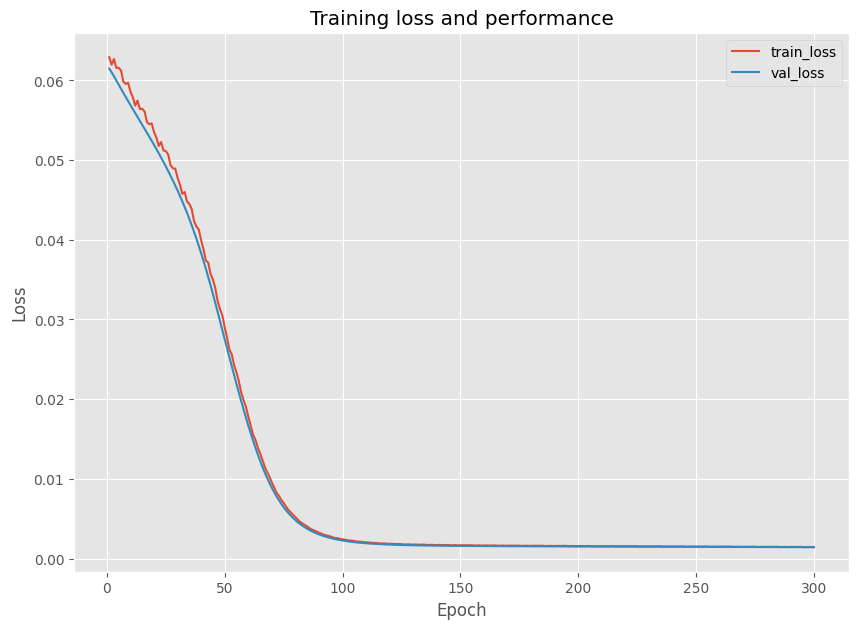

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
# plotting the training loss and accuracy
# plt.style.use("ggplot")
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, epoch+1), H.history["loss"], label="train_loss" )
plt.plot(np.arange(1, epoch+1), H.history["val_loss"], label="val_loss" )
# plt.ylim((0, 100))
plt.title("Training loss and performance")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
#plt.savefig("miniVGG_cifar10_40epochs_WITHOUT_learning_rate_decay.png")


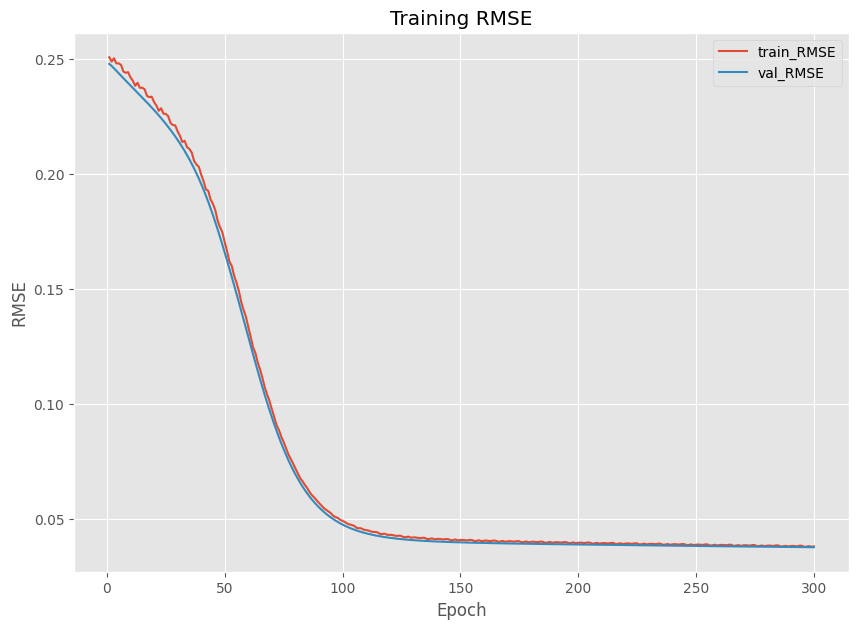

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
# plotting the training loss and accuracy
# plt.style.use("ggplot")
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, epoch+1), H.history["RMSE"], label="train_RMSE" )
plt.plot(np.arange(1, epoch+1), H.history["val_RMSE"], label="val_RMSE" )
# plt.ylim((0, 0.5))
plt.title("Training RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()
#plt.savefig("miniVGG_cifar10_40epochs_WITHOUT_learning_rate_decay.png")


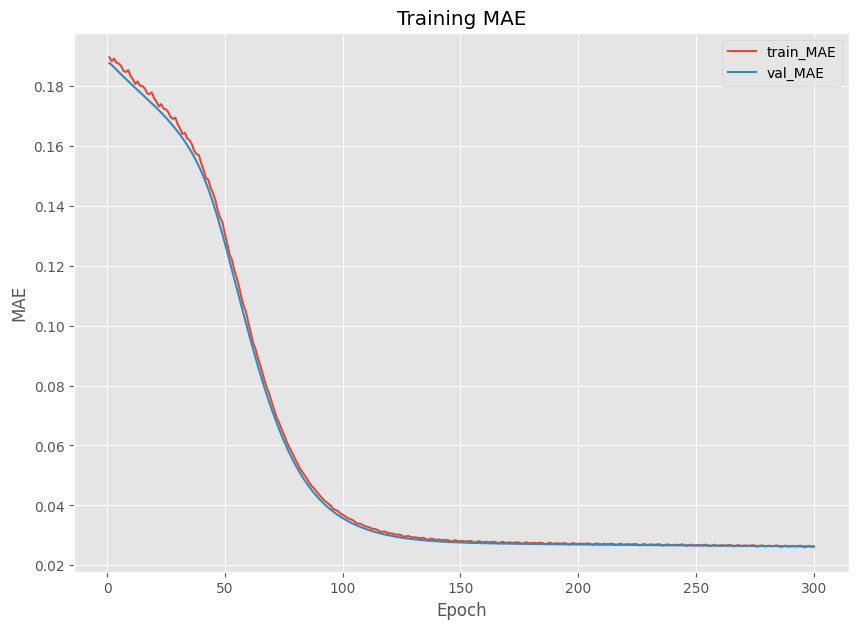

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
# plotting the training loss and accuracy
# plt.style.use("ggplot")
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, epoch+1), H.history["MAE"], label="train_MAE" )
plt.plot(np.arange(1, epoch+1), H.history["val_MAE"], label="val_MAE" )
plt.title("Training MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()
#plt.savefig("miniVGG_cifar10_40epochs_WITHOUT_learning_rate_decay.png")


In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, epoch+1), H.history["lr"], label="lr" )
plt.title("Learning Rate Decay")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.legend()
plt.show()

KeyError: 'lr'

<Figure size 1000x700 with 0 Axes>

#### **Saving the trained model to disk.**

In [ ]:
# The precess of saving and loading a trained model is called
# Model Serialization.
# print("[INFO] serializing network...")
# model.save("./Data/" + training_data_folder + "/SSRAN_100epochs_15:00_19_06_2023.hdf5")

In [ ]:
# print('The shape of Inputs Train_MSI:', Train_MSI_Patches.shape) # X
# print('The shape of Outputs Train_HSI:', Train_HSI_Patches.shape) # y - GT
# print()
# print('The shape of Inputs Test_MSI:', Test_MSI_Patches.shape) # X
# print('The shape of Outputs Test_HSI:', Test_HSI_Patches.shape) # y - GT

# **Test the performance of the model**
generate HSI using the trained model and compare it with the ground truth HSI

In [ ]:
patch_size = 50
stride = 25
batch_size = 64

### **Load saved model**

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Mean Squared Error (MSE) loss function
# Loss function used in SSRAN paper
def mse_loss(y_true, y_pred):
    L2_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return L2_loss

# https://stackoverflow.com/questions/45576576/keras-unknown-loss-function-error-after-defining-custom-loss-function
# https://stackoverflow.com/questions/57982158/valueerror-unknown-loss-functionfocal-loss-fixed-when-loading-model-with-my-cu
# https://github.com/keras-team/keras/issues/5916#issuecomment-300038263
model = load_model(filepath="./" + training_data_folder + "/models" + "/15_1_2024_14_9_0.hdf5",
                   custom_objects={"mse_loss" : mse_loss}
                   )

In [ ]:
!pwd

/gdrive/MyDrive/Colab Notebooks/Olds_college_code/SSRAN-main/Data


### **Load the test data**

In [ ]:
import h5py
db = h5py.File("./{}/test_50x50patches.hdf5".format(training_data_folder))

In [ ]:
list(db.keys())

['HSI_data', 'MSI_data']

In [ ]:
print("X_test.shape = ", db["MSI_data"].shape)
print("y_test.shape = ", db["HSI_data"].shape)

X_test.shape =  (96, 50, 50, 12)
y_test.shape =  (96, 50, 50, 235)


### **Evaluate Model**

In [ ]:
model.metrics_names

['loss', 'RMSE', 'MAE']

In [ ]:
model.evaluate(x=db["MSI_data"][...], y=db["HSI_data"][...], batch_size=batch_size)

2/2 [==============================] - 1s 481ms/step - loss: 0.0015 - RMSE: 0.0384 - MAE: 0.0266


[0.001476445235311985, 0.0384245365858078, 0.026600170880556107]

### **Predict Hyperspectral image**

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
y_pred = model.predict(x=db["MSI_data"][...], batch_size=batch_size, verbose=1)
y_pred = y_pred.astype(data_dtype)
print("y_pred.shape = ", y_pred.shape)


[INFO] evaluating network...
2/2 [==============================] - 0s 61ms/step
y_pred.shape =  (96, 50, 50, 235)


In [ ]:
print(y_pred.min(), y_pred.max())

-0.1104 0.7153


#### **Save the Predicted HSI cube**

In [ ]:
# from scipy.io import savemat
# savemat(file_name="./" + training_data_folder + "/y_pred_desis_landsat.mat", mdict={"y_pred" : y_pred})

## **Calculate Evaluation Metrics on the test set**

In [ ]:
# Root Mean Squared Error (RMSE)
# Spectral Angle Mapper (SAM)
# Universal Quality Image Index (UQI)
# Erreur Relative Globale Adimensionnelle de Synthèse (ERGAS)
# Peak Signal-to-Noise Ratio (PSNR)
# Structural Similarity Index (SSIM)
# Multi-scale Structural Similarity Index (MS-SSIM)
# from sewar.full_ref import rmse, sam, uqi, ergas, psnr, ssim, msssim

In [ ]:
from utils.evaluation_metrics import *

print("mae    = ", calc_mae(GT=db["HSI_data"], P=y_pred))
print("rmse   = ", calc_rmse(GT=db["HSI_data"], P=y_pred))
print("sam    = ", calc_sam(GT=db["HSI_data"], P=y_pred))
print("uqi    = ", calc_uqi(GT=db["HSI_data"], P=y_pred))
print("ergas  = ", calc_ergas(GT=db["HSI_data"], P=y_pred))
print("psnr   = ", calc_psnr(GT=db["HSI_data"], P=y_pred))
print("ssim   = ", calc_ssim(GT=db["HSI_data"], P=y_pred))


mae    =  0.0266
rmse   =  0.03415935518662268
sam    =  0.31642213688850834
uqi    =  0.8933803016957227
ergas  =  66.35243147957262
psnr   =  30.728606982265372
ssim   =  0.3232104545645474


In [ ]:
# show the MAE plot
def calc_mae_plot(GT, P):
    scores = []
    assert GT.shape[-1] == P.shape[-1], "Both matrics must have same number of channels/bands. {} != {}".format(GT.shape[-1], P.shape[-1])
    num_bands = GT.shape[-1]
    for i in range(num_bands):
        temp = []
        for k in range(GT.shape[0]):
            mae = np.mean(np.absolute(GT[k, :, :, i] - P[k, :, :, i]))
            temp.append(mae)
        scores.append(np.mean(temp))
    scores = np.array(scores)
    return scores

scores = calc_mae_plot(GT=db["HSI_data"][...], P=y_pred)
scores.shape

(235,)

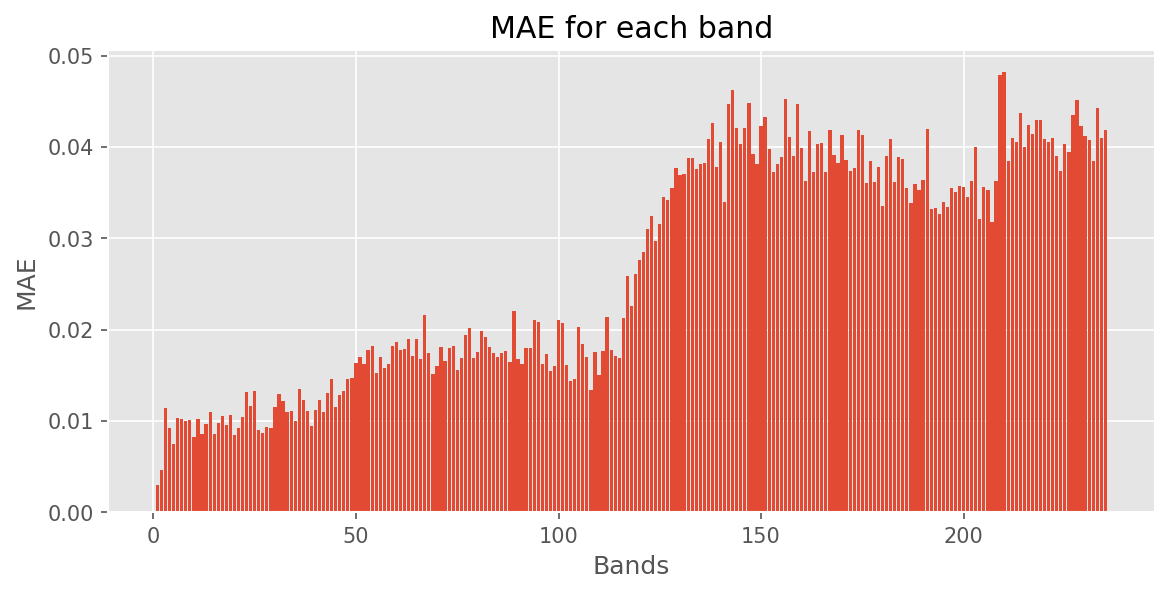

In [ ]:
plt.figure(figsize=(9, 4), dpi=150)
plt.bar(np.arange(1, 235+1, 1), scores)
plt.xlabel("Bands")
plt.ylabel("MAE")
plt.title("MAE for each band")
plt.show()

# plt.figure(figsize=(9, 4), dpi=150)
# plt.bar(np.linspace(400, 1000+1, 235), scores, color="blue")
# plt.xlabel("Wavelength (nm)")
# plt.ylabel("MAE")
# plt.title("MAE for each band")
# plt.show()

## **Visualize the Predicted HSI cube**

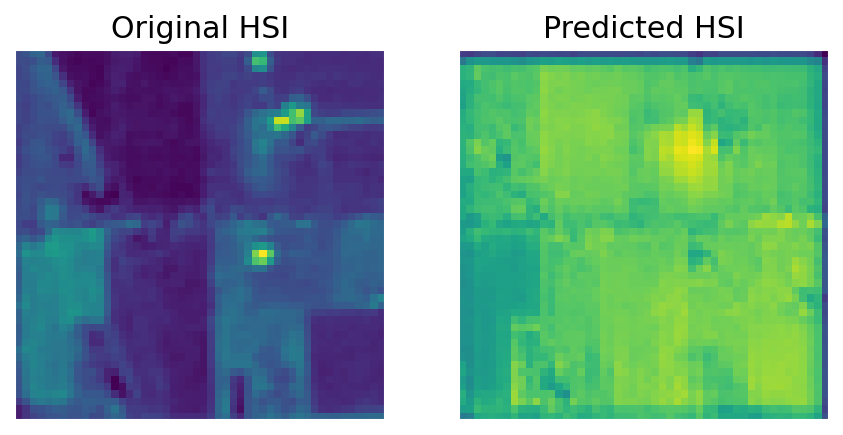

In [ ]:
band = 50

# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 7), dpi=150)

plt.subplot(1, 2, 1)
plt.imshow(X=db["HSI_data"][0, ..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Original HSI")

plt.subplot(1, 2, 2)
plt.imshow(X=y_pred[0, ..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Predicted HSI")
# plt.suptitle("Band: " + str(band))
plt.show()
plt.close()

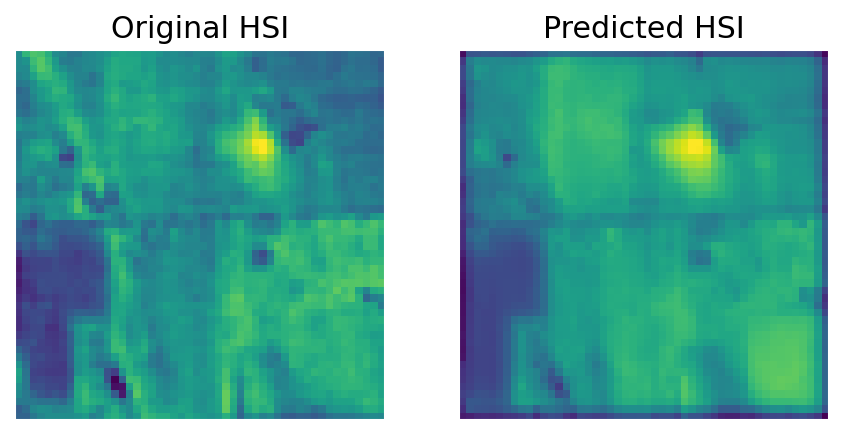

In [ ]:
band = 200

# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 7), dpi=150)

plt.subplot(1, 2, 1)
plt.imshow(X=db["HSI_data"][0, ..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Original HSI")

plt.subplot(1, 2, 2)
plt.imshow(X=y_pred[0, ..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Predicted HSI")
# plt.suptitle("Band: " + str(band))
plt.show()
plt.close()

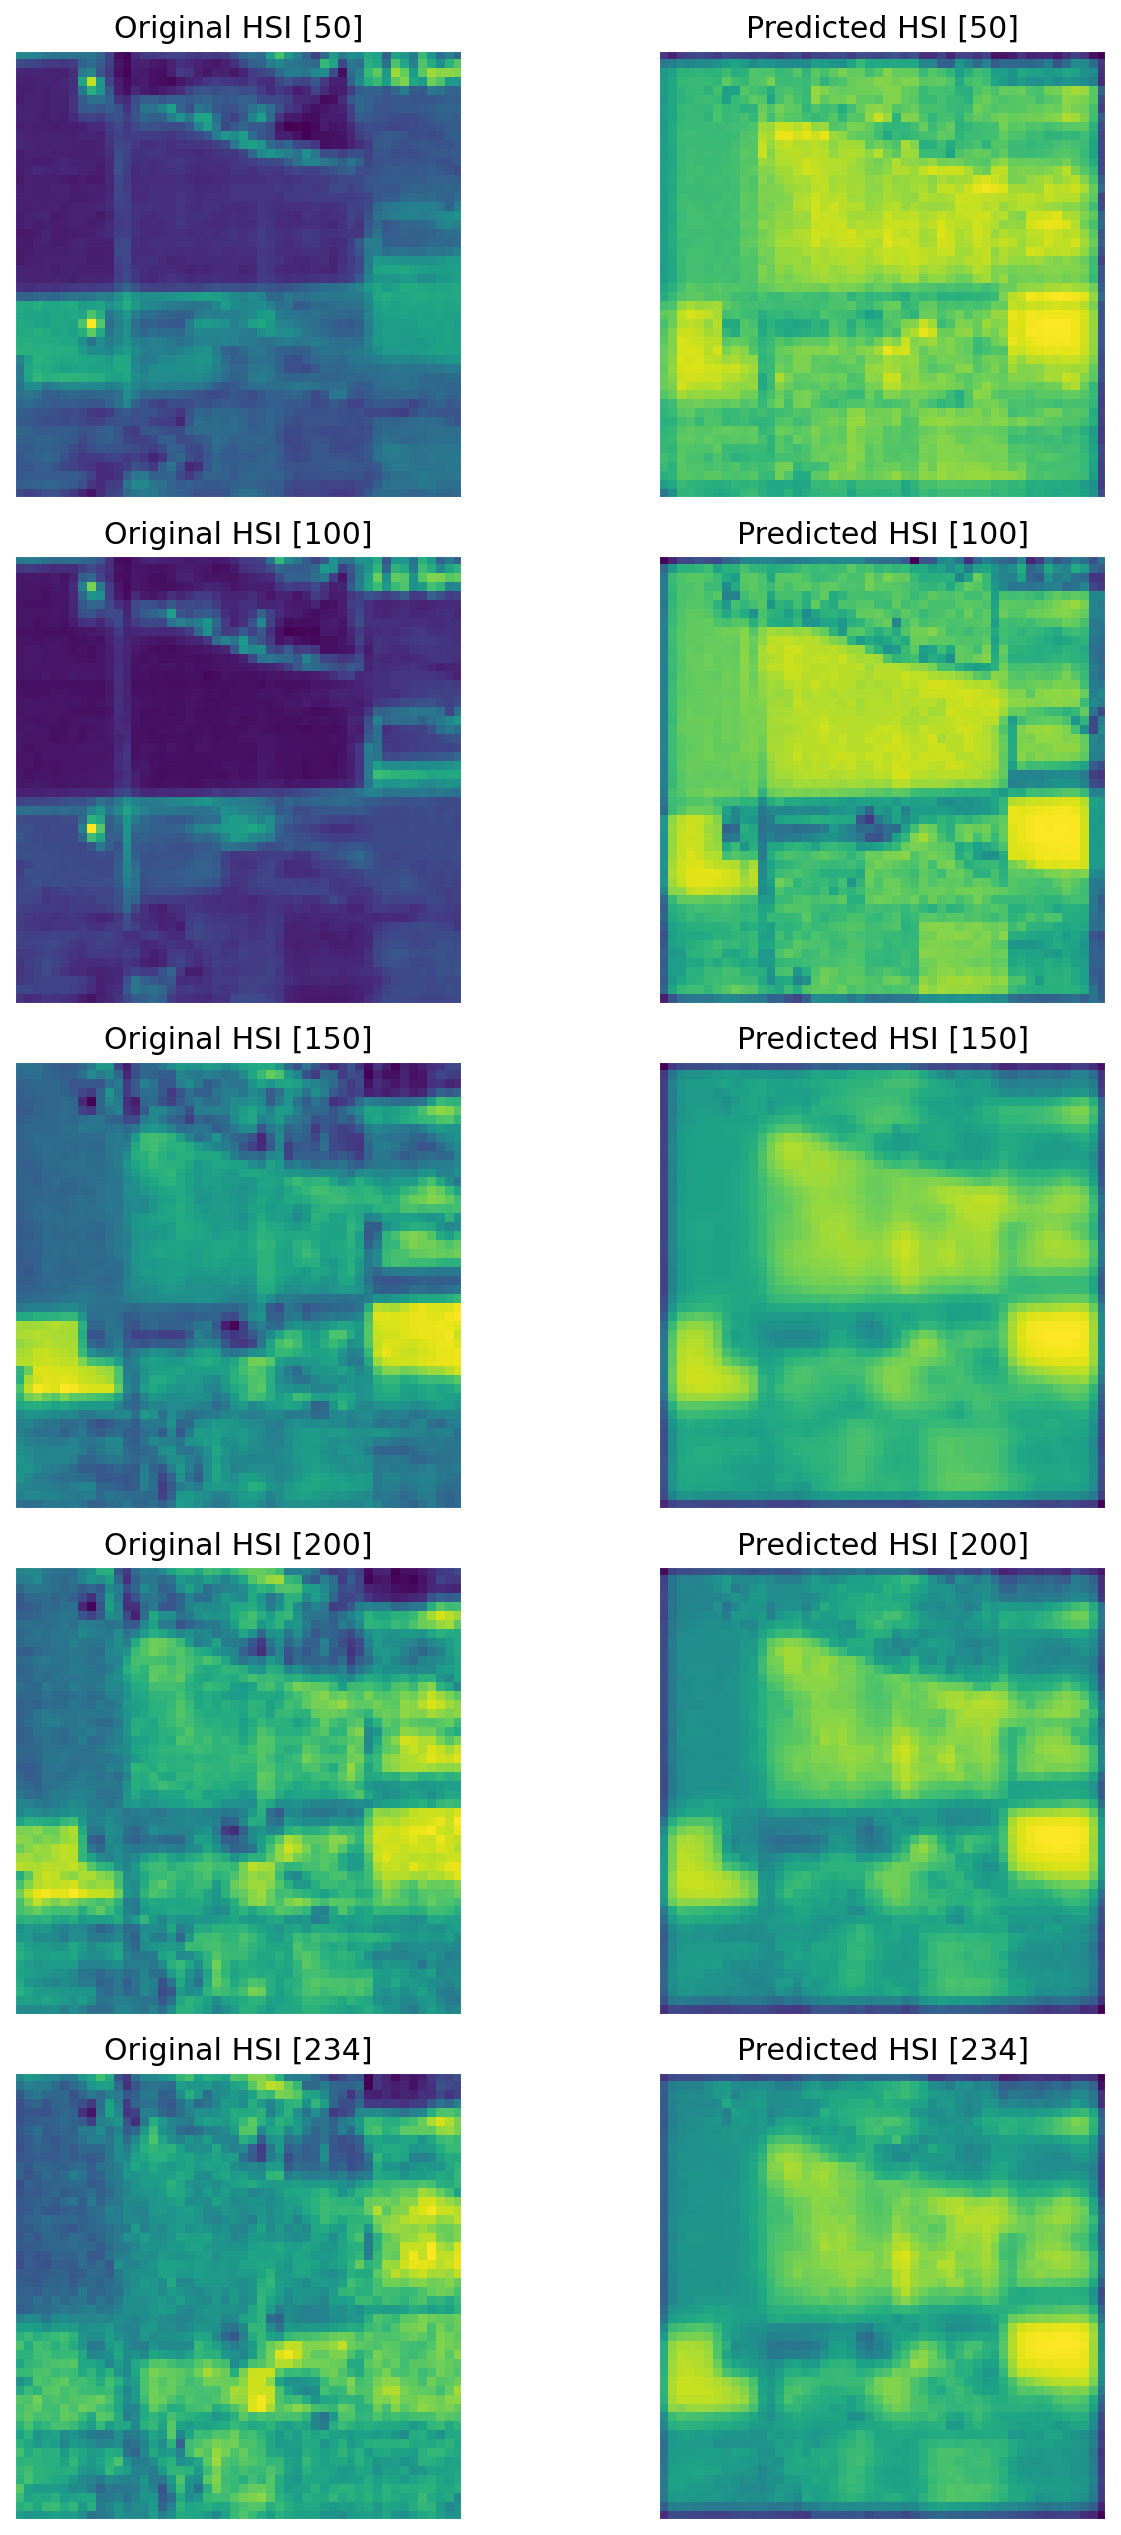

In [ ]:
band = [10, 50, 100, 150, 200, 234]

# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 17), dpi=150)

for i in range(1, 6):
    plt.subplot(5, 2, 2*i-1)
    plt.imshow(X=db["HSI_data"][10, ..., band[i]]) # plt.colorbar(label="Reflectance (%)")
    plt.xticks([]); plt.yticks([]);
    plt.title(label="Original HSI [{}]".format(band[i]))

    plt.subplot(5, 2, 2*i)
    plt.imshow(X=y_pred[10, ..., band[i]]) # plt.colorbar(label="Reflectance (%)")
    plt.xticks([]); plt.yticks([]);
    plt.title(label="Predicted HSI [{}]".format(band[i]))
# plt.suptitle("Band: " + str(band))
plt.tight_layout()
plt.show()
plt.close()

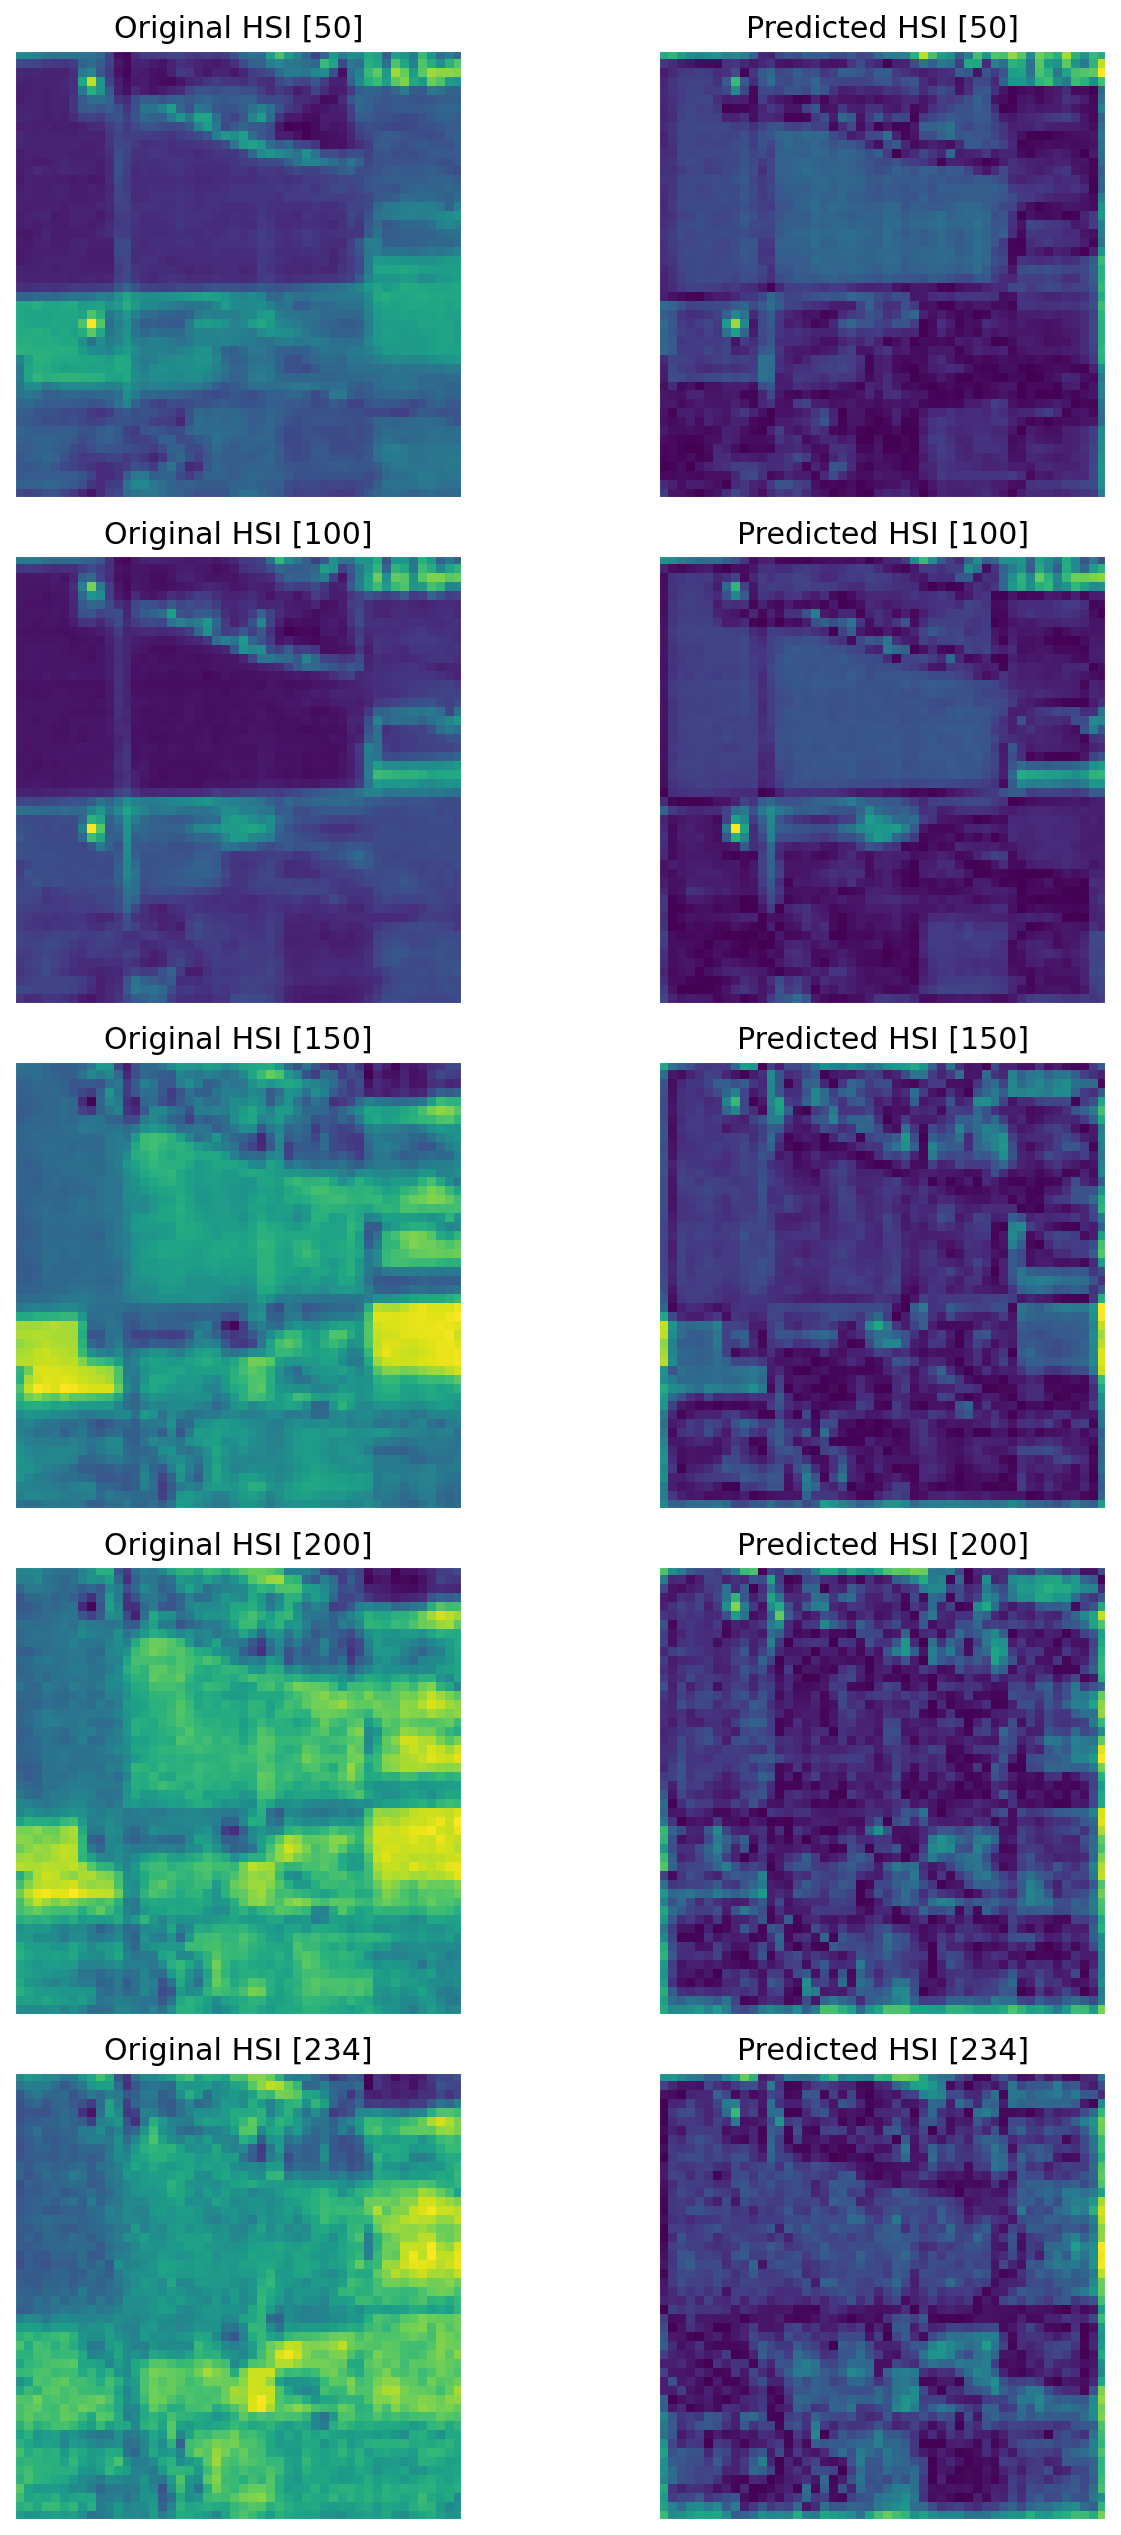

In [ ]:
band = [10, 50, 100, 150, 200, 234]

# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 17), dpi=150)

for i in range(1, 6):
    plt.subplot(5, 2, 2*i-1)
    plt.imshow(X=db["HSI_data"][10, ..., band[i]]) # plt.colorbar(label="Reflectance (%)")
    plt.xticks([]); plt.yticks([]);
    plt.title(label="Original HSI [{}]".format(band[i]))

    plt.subplot(5, 2, 2*i)
    plt.imshow(X=np.abs(db["HSI_data"][10, ..., band[i]] - y_pred[10, ..., band[i]])) # plt.colorbar(label="Reflectance (%)")
    plt.xticks([]); plt.yticks([]);
    plt.title(label="Predicted HSI [{}]".format(band[i]))
# plt.suptitle("Band: " + str(band))
plt.tight_layout()
plt.show()
plt.close()

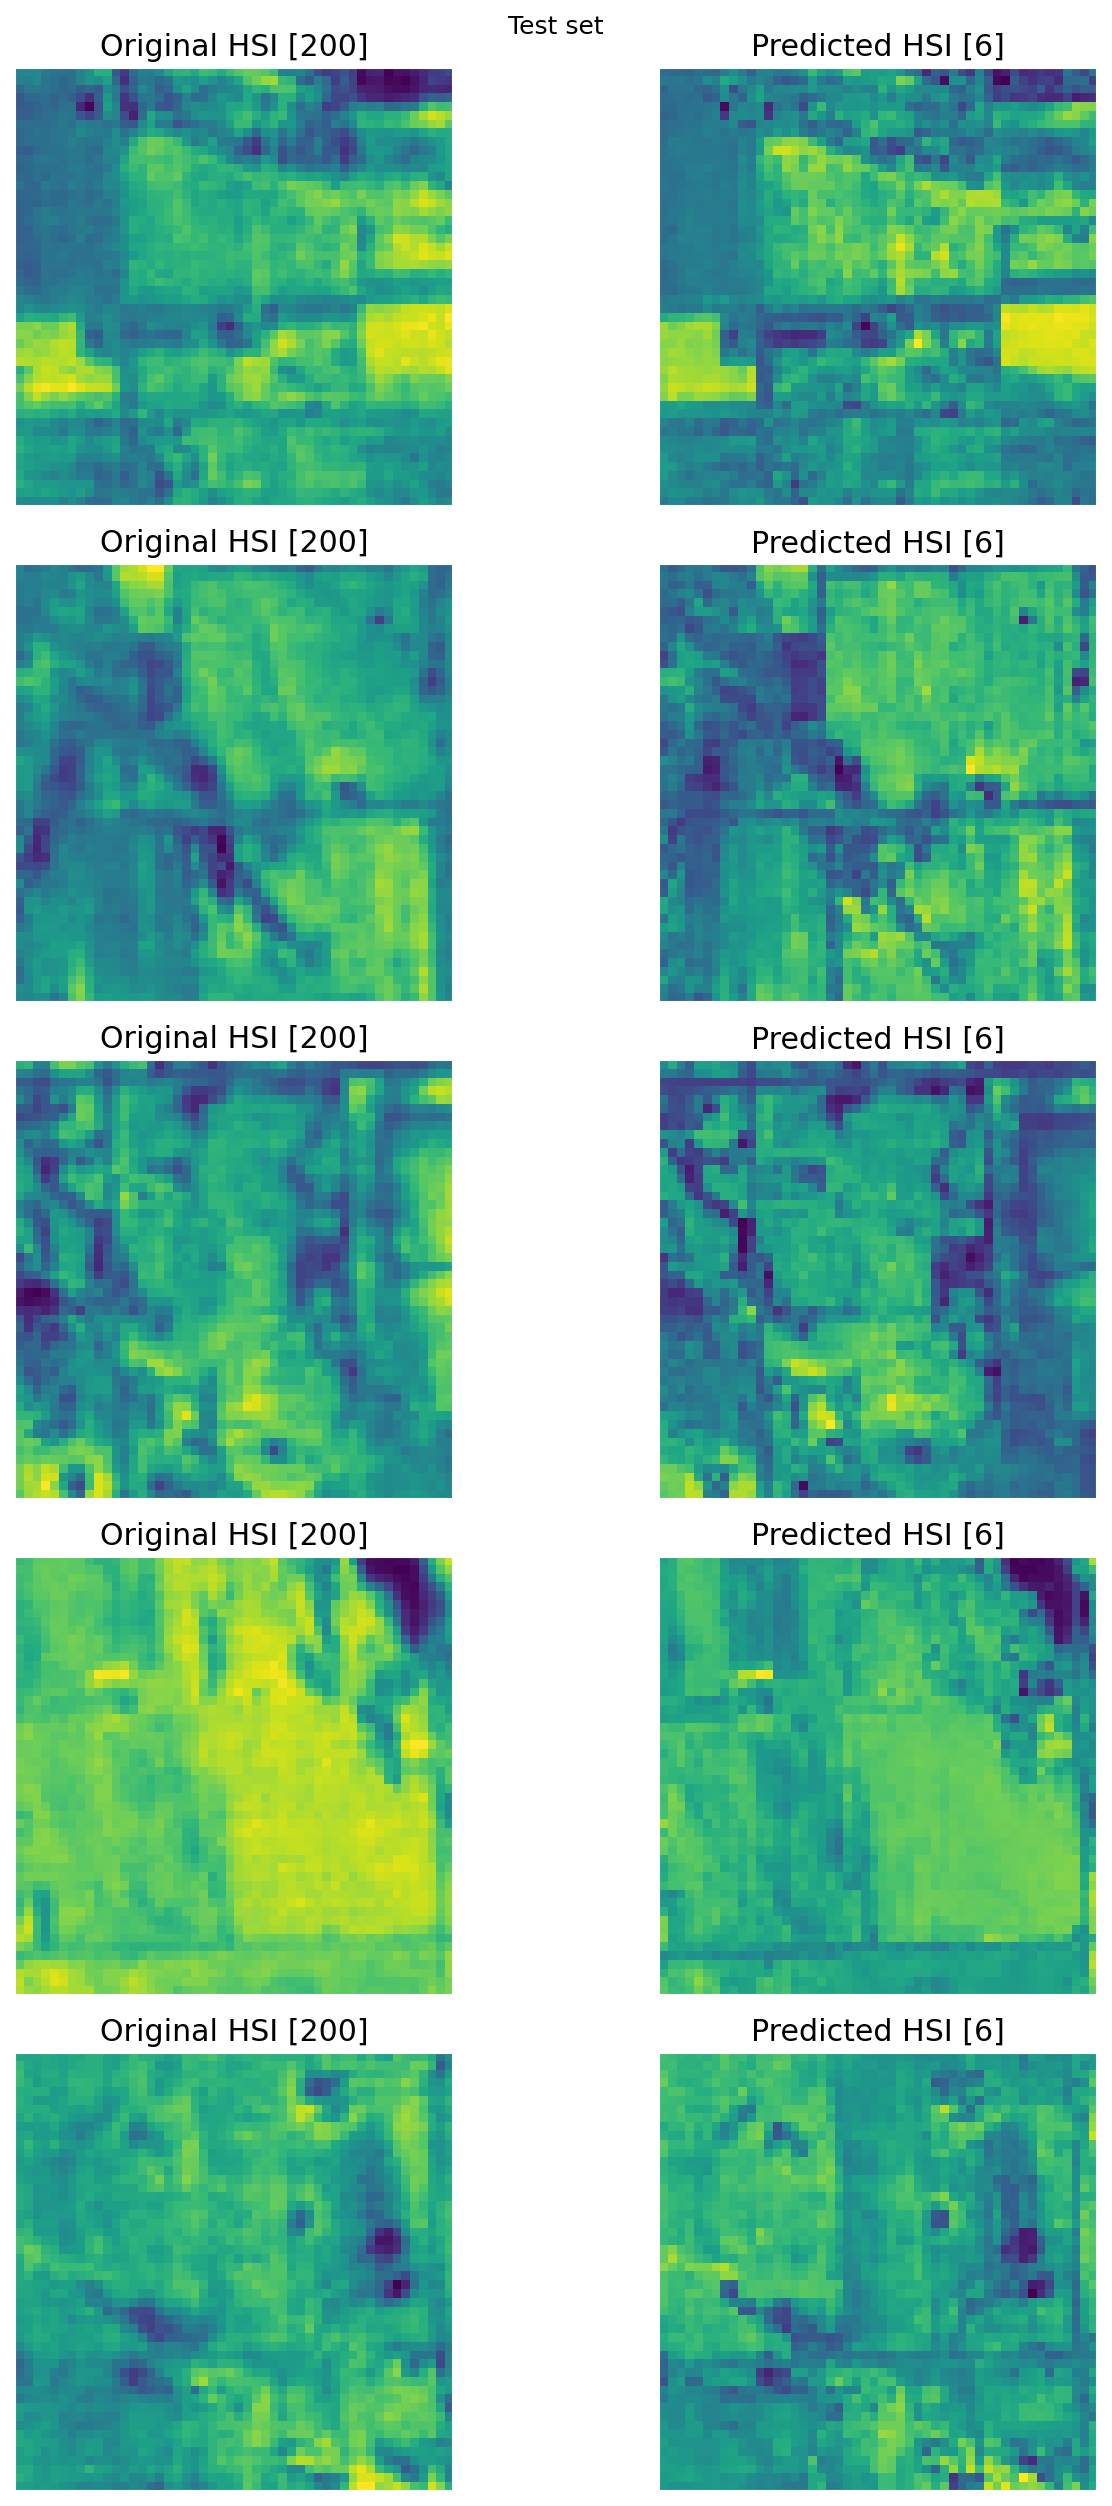

In [ ]:
sample = [0, 10, 30, 50, 70, 90] # for validation and test set
# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 17), dpi=150)

for i in range(1, 6):
    plt.subplot(5, 2, 2*i-1)
    plt.imshow(X=db["HSI_data"][sample[i], ..., 200]) # plt.colorbar(label="Reflectance (%)")
    plt.xticks([]); plt.yticks([]);
    plt.title(label="Original HSI [{}]".format(200))

    plt.subplot(5, 2, 2*i)
    plt.imshow(X=db["MSI_data"][sample[i], ..., 6]) # plt.colorbar(label="Reflectance (%)")
    plt.xticks([]); plt.yticks([]);
    plt.title(label="Predicted HSI [{}]".format(6))
plt.suptitle("{} set".format("Test"))
plt.tight_layout()
plt.show()
plt.close()

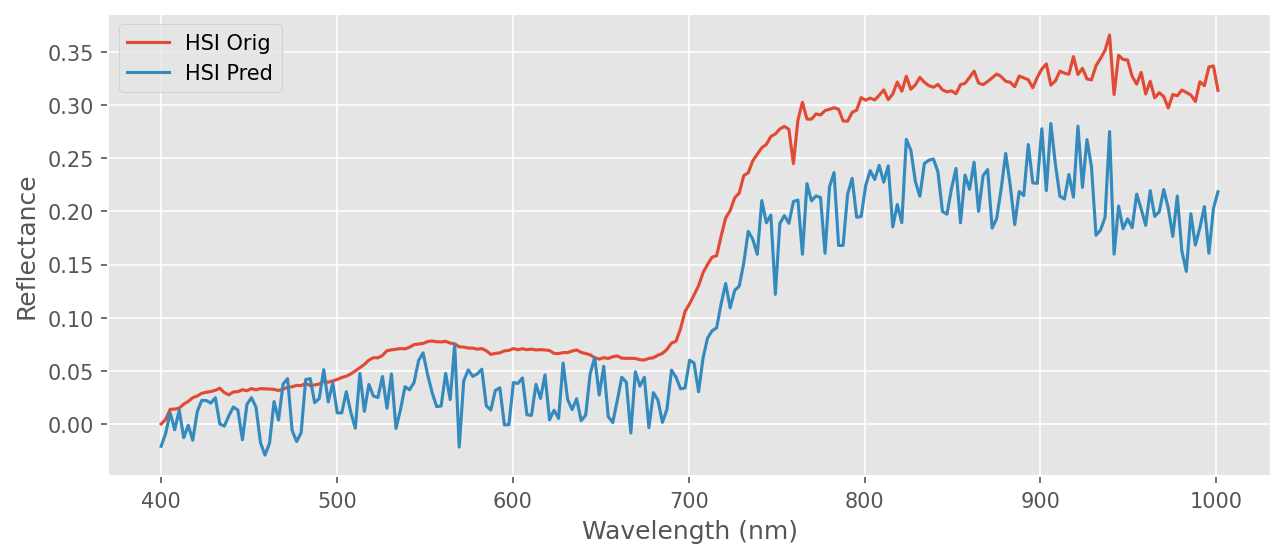

In [ ]:
plt.figure(figsize=(10, 4), dpi=150)
x_values = np.linspace(400, 1000+1, 235)
plt.plot(x_values, db["HSI_data"][10, 0, 0, :], label="HSI Orig")
plt.plot(x_values, y_pred[10, 0, 0, :], label="HSI Pred")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
# plt.grid()
plt.legend()
plt.show()

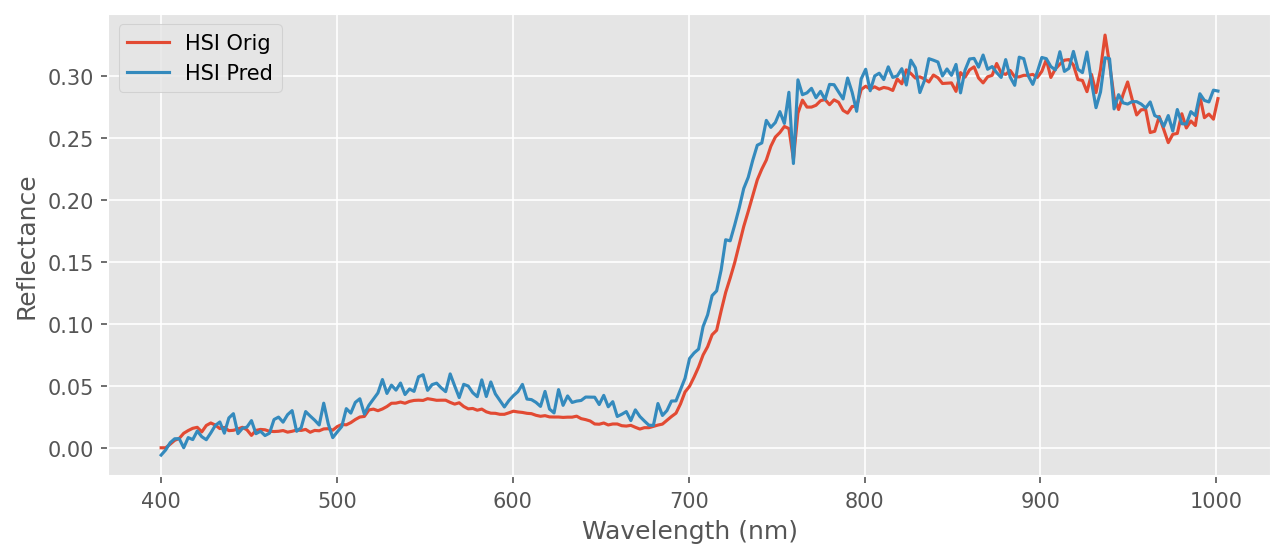

In [ ]:
plt.figure(figsize=(10, 4), dpi=150)
x_values = np.linspace(400, 1000+1, 235)
plt.plot(x_values, db["HSI_data"][10, 2, 1, :], label="HSI Orig")
plt.plot(x_values, y_pred[10, 2, 1, :], label="HSI Pred")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
# plt.grid()
plt.legend()
plt.show()

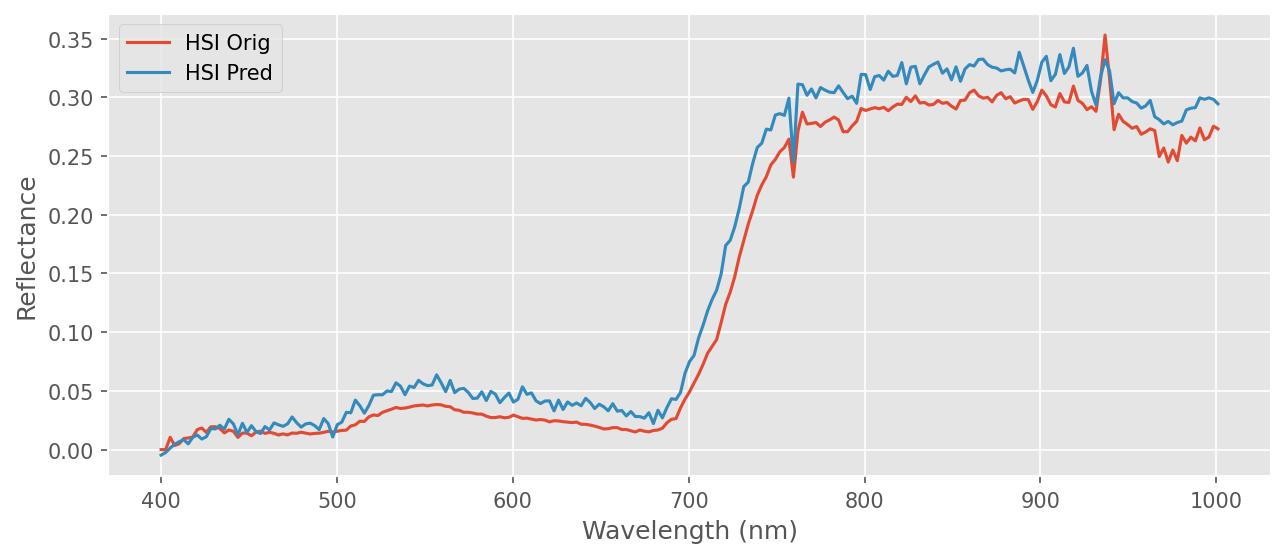

In [ ]:
plt.figure(figsize=(10, 4), dpi=150)
x_values = np.linspace(400, 1000+1, 235)
plt.plot(x_values, db["HSI_data"][10, 3, 2, :], label="HSI Orig")
plt.plot(x_values, y_pred[10, 3, 2, :], label="HSI Pred")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
# plt.grid()
plt.legend()
plt.show()

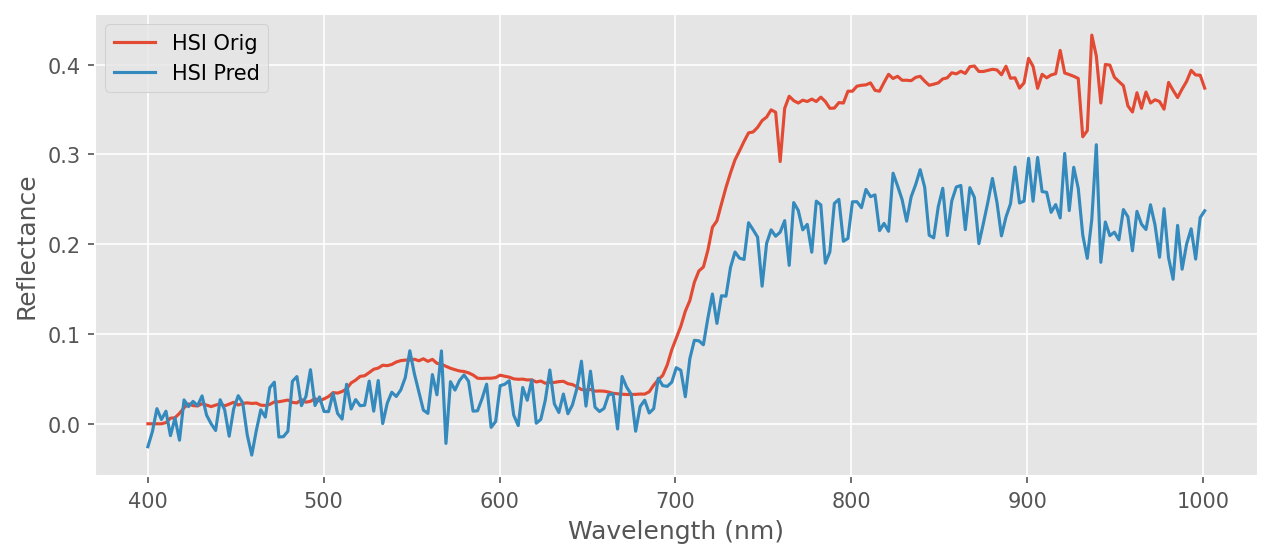

In [ ]:
plt.figure(figsize=(10, 4), dpi=150)
x_values = np.linspace(400, 1000+1, 235)
plt.plot(x_values, db["HSI_data"][50, 0, 0, :], label="HSI Orig")
plt.plot(x_values, y_pred[50, 0, 0, :], label="HSI Pred")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
# plt.grid()
plt.legend()
plt.show()

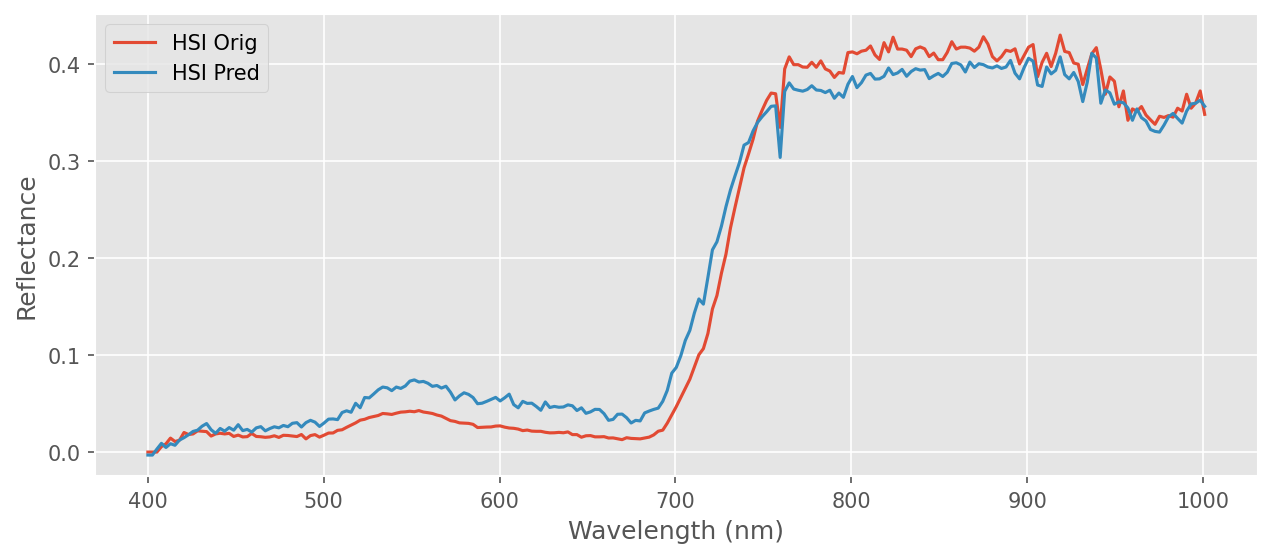

In [ ]:
plt.figure(figsize=(10, 4), dpi=150)
x_values = np.linspace(400, 1000+1, 235)
plt.plot(x_values, db["HSI_data"][80, 2, 2, :], label="HSI Orig")
plt.plot(x_values, y_pred[80, 2, 2, :], label="HSI Pred")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
# plt.grid()
plt.legend()
plt.show()

# **Delete experiment plots and saved models.**

In [ ]:
# if a particular experiment does not go well, and I wish to remove the saved models,
# then, use the below function.
def delete_saved_models_and_plots(date_time_str):
    import glob

    # delete saved models
    models_path = "./{}/models".format(training_data_folder)
    print()
    for file_path in sorted(glob.glob(models_path + "/{}.hdf5".format(date_time_str))):
        if os.path.exists(file_path):
            os.remove(file_path)
            print("[INFO] Deleted model: ", os.path.basename(file_path))

    # delete saved plots and the .json file
    plots_path = "./{}/plots".format(training_data_folder)
    print()
    for file_path in sorted(glob.glob(plots_path + "/{}*".format(date_time_str))):
        if os.path.exists(file_path):
            os.remove(file_path)
            print("[INFO] Deleted plot: ", os.path.basename(file_path))

# delete_saved_models_and_plots()

# **Old Section**

### **Merge the Test patches into whole HSI image**

In [ ]:
# Testing_MSI.shape =  (560, 1131, 7)
# Testing_HSI.shape =  (560, 1131, 235)

In [ ]:
def merge_patches(patches, image_size, patch_size):
    height, width, channels = image_size
    num_patches_h = height // patch_size
    num_patches_w = width // patch_size
    num_patches = num_patches_h * num_patches_w
    assert num_patches == patches.shape[0]

    # initialize output image
    output_image = np.zeros(image_size)

    # merge patches into output image
    idx = 0
    for i in range(0, num_patches_h, 1):
        for j in range(0, num_patches_w, 1):
            h_start = i*patch_size
            w_start = j*patch_size
            h_end = h_start + patch_size
            w_end = w_start + patch_size
            output_image[h_start:h_end, w_start:w_end] = patches[idx]
            idx += 1

    assert idx == num_patches

    return output_image


In [ ]:
Testing_HSI.shape

In [ ]:
y_pred_HSI = merge_patches(patches=y_pred, image_size=Testing_HSI.shape, patch_size=patch_size)
print(y_pred_HSI.shape)

In [ ]:
(y_pred_HSI.min(), y_pred_HSI.max())

In [ ]:
band = 50

# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11, 11), dpi=150)

plt.subplot(1, 2, 1)
plt.imshow(X=Testing_HSI[..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Original HSI")

plt.subplot(1, 2, 2)
plt.imshow(X=y_pred_HSI[..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Predicted HSI")
# plt.suptitle("Band: " + str(band))
plt.show()
plt.close()

In [ ]:
band = 100

# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11, 11), dpi=150)

plt.subplot(1, 2, 1)
plt.imshow(X=Testing_HSI[..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Original HSI")

plt.subplot(1, 2, 2)
plt.imshow(X=y_pred_HSI[..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Predicted HSI")
# plt.suptitle("Band: " + str(band))
plt.show()
plt.close()

In [ ]:
band = 200

# Show the FINAL VIS output in a single plot.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11, 11), dpi=150)

plt.subplot(1, 2, 1)
plt.imshow(X=Testing_HSI[..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Original HSI")

plt.subplot(1, 2, 2)
plt.imshow(X=y_pred_HSI[..., band]) # plt.colorbar(label="Reflectance (%)")
plt.xticks([]); plt.yticks([]);
plt.title(label="Predicted HSI")
# plt.suptitle("Band: " + str(band))
plt.show()
plt.close()

# **New Section**